In [66]:
#importation of libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import yfinance as yf
import pandas as pd
import seaborn as sns

from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, t
from tqdm import tqdm

# Pricing and Risk Analysis of a Worst-of Autocallable Structured Product

In this notebook, we analyze and simulate a structured financial product known as a *Worst-of European Barrier Autocallable Equity-Linked Security*. This type of product is linked to the performance of a basket of underlying stocks, and offers conditional early redemption (autocall) and coupon payments depending on the worst-performing asset in the basket.

The main features of this product include:
- A quarterly observation schedule for potential early redemption (autocall),
- A fixed coupon paid if no autocall is triggered and the worst stock remains above a certain coupon barrier,
- A capital protection mechanism dependent on a final maturity barrier (European-style).

---

### Objectives of this notebook

- **Model and simulate** the dynamics of the underlying assets using stochastic processes (e.g., geometric Brownian motion, Student-t model).
- **Incorporate empirical correlations** and possibly stochastic or time-varying covariance structures.
- **Price the structured product** through Monte Carlo and Quasi-Monte Carlo simulations.
- **Analyze key risk metrics** such as the probability of early redemption, average payoff, and exposure to market risk.

We will use real historical data for calibration and backtest the assumptions to ensure consistency with observed market behavior.

---

### Benefits and Risks

**Potential Benefits:**
- Attractive fixed coupons compared to traditional fixed-income products.
- Possibility of early redemption if market conditions are favorable.
- Some downside protection if the worst-performing stock remains above the maturity barrier.

**Key Risks:**
- Performance is driven by the worst-performing stock in the basket (worst-of effect).
- No coupon is paid if the worst stock drops below the coupon barrier.
- Capital is at risk if the worst stock is below the maturity barrier at final observation.
- Limited upside: investor does not benefit from strong performance of best stocks.

---

### Best-Case Scenario

- The worst-performing stock stays above the autocall barrier during the first observation date (e.g., after 1 year).
- The product is called early, and the investor receives **100% of the notional + accrued coupons**.

---

### Worst-Case Scenario

- None of the autocall conditions are met throughout the life of the product.
- The worst-performing stock falls below the final maturity barrier.
- The investor receives only a fraction of the capital (proportional to the worst-performing stock's final level), and **no coupons are paid**.



## Market : 

- The conversion rate between yen and euros is important in our case, because the product is in euro, here is the exchange rate EUR/JPY for the last 20 years.
- Moreover, we plot the historical trend of the underlying assets


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_80251/104009401.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eurjpy = yf.download("EURJPY=X",period='10y')["Close"]
[*********************100%***********************]  1 of 1 completed


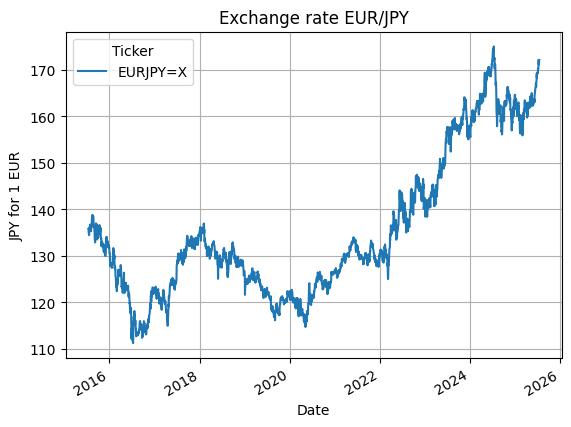

In [67]:
eurjpy = yf.download("EURJPY=X",period='10y')["Close"]

# Plot exchange rate
eurjpy.plot(title="Exchange rate EUR/JPY")
plt.xlabel("Date")
plt.ylabel("JPY for 1 EUR")
plt.grid(True)
plt.show()

In [68]:
#data of underlying assets
tickers = ['TTE.PA', 'ASML', 'EN.PA', 'RI.PA']
data = yf.download(tickers, start="2022-01-01", end="2025-06-15")

/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_80251/917446441.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2022-01-01", end="2025-06-15")
[*********************100%***********************]  4 of 4 completed


In [69]:
#most recent prices of the assets
latest_prices = {'TTE.PA': np.float64(53.87),
                 'ASML.AS': np.float64(683.90),
                 'EN.PA': np.float64(38.51), 
                 'RI.PA': np.float64(94.74)}

latest_prices = np.array(list(latest_prices.values()))

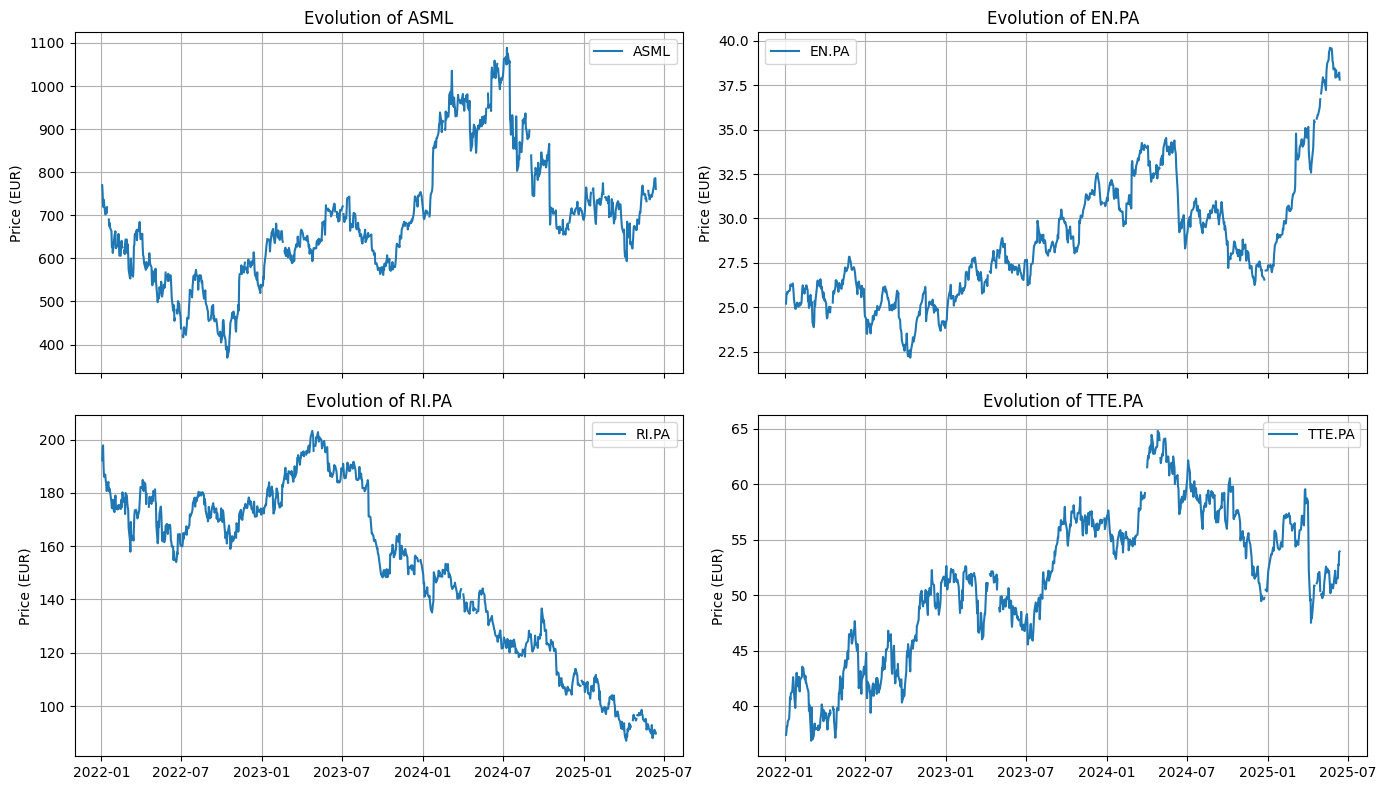

In [70]:
#plot of the assets
close_prices = data.xs('Close', axis=1, level='Price')

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
axes = axs.flatten()

for i, ticker in enumerate(close_prices.columns):
    axes[i].plot(close_prices.index, close_prices[ticker], label=ticker)
    axes[i].set_title(f"Evolution of {ticker}")
    axes[i].set_ylabel("Price (EUR)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

## Model :

### Beginning : 

At first, we want to implement a simple Geometric Brownian Motion (GBM) for the assets. Here is the model equation : 

${\displaystyle dS_{t}=\mu S_{t}\,dt+\sigma S_{t}\,dW_{t}}$

with :
- $\mu$ : drift
- $W_t$ : Brownian motion
- $S_t$ : price of the underlying asset
- $\sigma(S_t,t)$ : volatility

In order to implement this model, we need volatility, drift and correlation.

In [71]:
T = 10.0       # total time (10 years)
N_steps = 2268     # number of steps (trading days)
dt = T / N_steps
M = 1000        # number of MC simulations

d = 4  # number of assets 

dt = 1/252

In [72]:
#Volatility
close_prices = data.xs('Close', axis=1, level='Price')
returns = close_prices.pct_change().dropna()
print(returns)
vol = returns.std() * np.sqrt(252) #annual vol
print(vol)


Ticker          ASML     EN.PA     RI.PA    TTE.PA
Date                                              
2022-01-04 -0.022947  0.019739  0.025678  0.008446
2022-01-05 -0.043019  0.005308  0.003245  0.012012
2022-01-06  0.023402 -0.002485 -0.036968  0.000436
2022-01-07 -0.009199  0.003736 -0.023512  0.011429
2022-01-10 -0.038262  0.001861  0.004423  0.006027
...              ...       ...       ...       ...
2025-06-09  0.022815 -0.000525  0.031591  0.000574
2025-06-10  0.019177 -0.002365  0.003745  0.024078
2025-06-11 -0.001121  0.003687 -0.012511 -0.000746
2025-06-12  0.002704  0.002886  0.004890  0.022222
2025-06-13 -0.032065 -0.010466 -0.007963  0.001096

[890 rows x 4 columns]
Ticker
ASML      0.430269
EN.PA     0.191624
RI.PA     0.238736
TTE.PA    0.251338
dtype: float64


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_80251/4165159322.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = close_prices.pct_change().dropna()


Here is the correlation matrix of the assets.

In [73]:
close_prices = data['Close']

log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
correlation_matrix = log_returns.corr()

print(correlation_matrix)

Ticker      ASML     EN.PA     RI.PA    TTE.PA
Ticker                                        
ASML    1.000000  0.139506  0.191259  0.135881
EN.PA   0.139506  1.000000  0.258970  0.301889
RI.PA   0.191259  0.258970  1.000000  0.159557
TTE.PA  0.135881  0.301889  0.159557  1.000000


In [74]:
# 1. Log-returns
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

# 2. Correlation matrix
correlation_matrix = log_returns.corr()

# 3. Empirical volatilities (std of returns)
volatilities = log_returns.std()  # shape: (d,)

# 4. Construction of covariance matrix
covariance_matrix = correlation_matrix.values * np.outer(volatilities, volatilities)

covariance_matrix


array([[7.73944229e-04, 4.76206121e-05, 8.12346926e-05, 5.94456285e-05],
       [4.76206121e-05, 1.50555098e-04, 4.85133627e-05, 5.82507753e-05],
       [8.12346926e-05, 4.85133627e-05, 2.33092686e-04, 3.83079212e-05],
       [5.94456285e-05, 5.82507753e-05, 3.83079212e-05, 2.47294336e-04]])

### SABR Model

We cannot use the SABR model for a worst-of autocall because SABR is a univariate model designed for vanilla European options on a single underlying. However, a worst-of autocall is a multi-asset, path-dependent product requiring the joint simulation of multiple asset paths and the dynamic evaluation of their minimum, which SABR cannot model.

---

$\Rightarrow$ Monte Carlo simulation with drift  $\mu$ estimated from risk-free rates (e.g. €STR, SOFR, interpolated OIS, or TONA for yen), and volatility $\sigma$ estimated from implied volatility.

### Implied volatility : 

Unfortunately, we do not have the data to calculate the implied volatility of every asset, we only can calculate implied volatility for ASML.

In [75]:
target_expiry = '2025-01-17'
target_date = datetime.strptime(target_expiry, '%Y-%m-%d')

def historical_volatility(ticker_symbol, window_days=252):
    ticker = yf.Ticker(ticker_symbol)
    hist = ticker.history(period=f"{window_days}d")
    returns = np.log(hist['Close'] / hist['Close'].shift(1)).dropna()
    vol = returns.std() * np.sqrt(252)  # annual
    return vol

for symbol in tickers:
    try:
        ticker = yf.Ticker(symbol)
        spot = ticker.history(period="1d")['Close'].iloc[-1]

        expirations = ticker.options
        if not expirations:
            print(f"{symbol}: No options available, we take the historical value")
            vol_hist = historical_volatility(symbol)
            print(f"{symbol} - Spot: {spot:.2f} € - Historical volatility (1 year) : {vol_hist:.2%}")
            print("-" * 40)
            continue

        # Find the nearest expiration date >= target_date
        valid_expiries = [datetime.strptime(d, '%Y-%m-%d') for d in expirations if datetime.strptime(d, '%Y-%m-%d') >= target_date]
        if not valid_expiries:
            # No expiration after target_date, we take the farest available
            expiry_date = max([datetime.strptime(d, '%Y-%m-%d') for d in expirations])
        else:
            expiry_date = min(valid_expiries)

        expiry_str = expiry_date.strftime('%Y-%m-%d')
        opt_chain = ticker.option_chain(expiry_str)
        calls = opt_chain.calls

        # Find ATM
        atm_row = calls.iloc[(calls['strike'] - spot).abs().argmin()]
        sigma_atm = atm_row['implied Volatility']

        print(f"{symbol} - Spot: {spot:.2f} €")
        print(f"Expiration used here: {expiry_str}")
        print(f"Strike ATM: {atm_row['strike']:.2f} €")
        print(f"Implicit volatility ATM: {sigma_atm:.2%}")
        print("-" * 40)
        
    except Exception as e:
        print(f"Error with {symbol}: {e}")


TTE.PA: No options available, we take the historical value
TTE.PA - Spot: 53.99 € - Historical volatility (1 year) : 21.85%
----------------------------------------
Error with ASML: 'implied Volatility'
EN.PA: No options available, we take the historical value
EN.PA - Spot: 38.47 € - Historical volatility (1 year) : 18.44%
----------------------------------------
RI.PA: No options available, we take the historical value
RI.PA - Spot: 92.86 € - Historical volatility (1 year) : 27.18%
----------------------------------------


We only have 1 element in the list, because it's not able to calculate the implied volatility for the others 

### Historical vol : 

We thought that maybe because of the geopolitical situation, the implied volatility would be different to what's expected, so we thought maybe we could create diffents scenari : what would happend in a different context like pre Covid and after Covid.

In [76]:
volatility_records = []

In [77]:
def get_valid_cols_and_fill(data, tol=0.05):
    # Interpolate and fullfill NaN in all the DataFrame
    data_interp = data.interpolate(method='linear').ffill().bfill()
    n_rows = data_interp.shape[0]
    valid_cols = []
    for col in data_interp.columns:
        n_missing = data[col].isnull().sum()  # number de NaN before interpolation
        if n_missing / n_rows <= tol:
            valid_cols.append(col)
    return data_interp[valid_cols]

In [78]:
def compute_returns_and_stats(data):
    returns = np.log(data / data.shift(1)).dropna()
    vols = returns.std() * np.sqrt(252)
    corr = returns.corr()
    return vols, corr

We calculate the historical volatility for 3 differents periods : the last year, before Covid and the past three years to see the differences.

In [79]:
periods = {
    "Past 3 years": ("2022-01-04","2025-07-01")
}

for period_name, (start, end) in periods.items():
    print(f"\n--- {period_name} ---")
    data = yf.download(tickers, start=start, end=end)
    data_filled = get_valid_cols_and_fill(data)
    if data_filled.empty:
        print("Not valid tickers on the considered duration")
        continue

    close_cols = data_filled.columns[data_filled.columns.get_level_values(0) == 'Close']
    data_close = data_filled[close_cols]

    vols, corr = compute_returns_and_stats(data_close)

    for col in close_cols:
        ticker = col[1]
        vol = vols[col]
        print(f"{col} - Annual Vol : {vol:.2%}")
        volatility_records.append({
            "ticker": ticker,
            "vol": vol
        })

    print("\nCorrelation Matrix :")
    print(corr)
    print("-" * 50)


/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_80251/442471866.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)
[*********************100%***********************]  4 of 4 completed


--- Past 3 years ---
('Close', 'ASML') - Annual Vol : 42.71%
('Close', 'EN.PA') - Annual Vol : 19.12%
('Close', 'RI.PA') - Annual Vol : 23.68%
('Close', 'TTE.PA') - Annual Vol : 25.03%

Correlation Matrix :
Price            Close                              
Ticker            ASML     EN.PA     RI.PA    TTE.PA
Price Ticker                                        
Close ASML    1.000000  0.143456  0.184302  0.129901
      EN.PA   0.143456  1.000000  0.253956  0.289345
      RI.PA   0.184302  0.253956  1.000000  0.151114
      TTE.PA  0.129901  0.289345  0.151114  1.000000
--------------------------------------------------


In [80]:
df_vols = pd.DataFrame(volatility_records)
df_vols

,ticker,vol
0,ASML,0.427068
1,EN.PA,0.191236
2,RI.PA,0.236794
3,TTE.PA,0.250287


For the following, we will only use data for the past three years.

### Drift : 

The currency is EUR€ so we use the overnight risk-free rate €STR, which is the risk-free rate for a deposite on the target 2 platform. The rate is : 1.922, so we choose a risk-free drift $\mu=0.01922$ 

In [81]:
mu = 0.01922

### Normality test : 

We want to do a normality test to see if the returns have a gaussian behaviour.

In [82]:
returns.columns

Index(['ASML', 'EN.PA', 'RI.PA', 'TTE.PA'], dtype='object', name='Ticker')

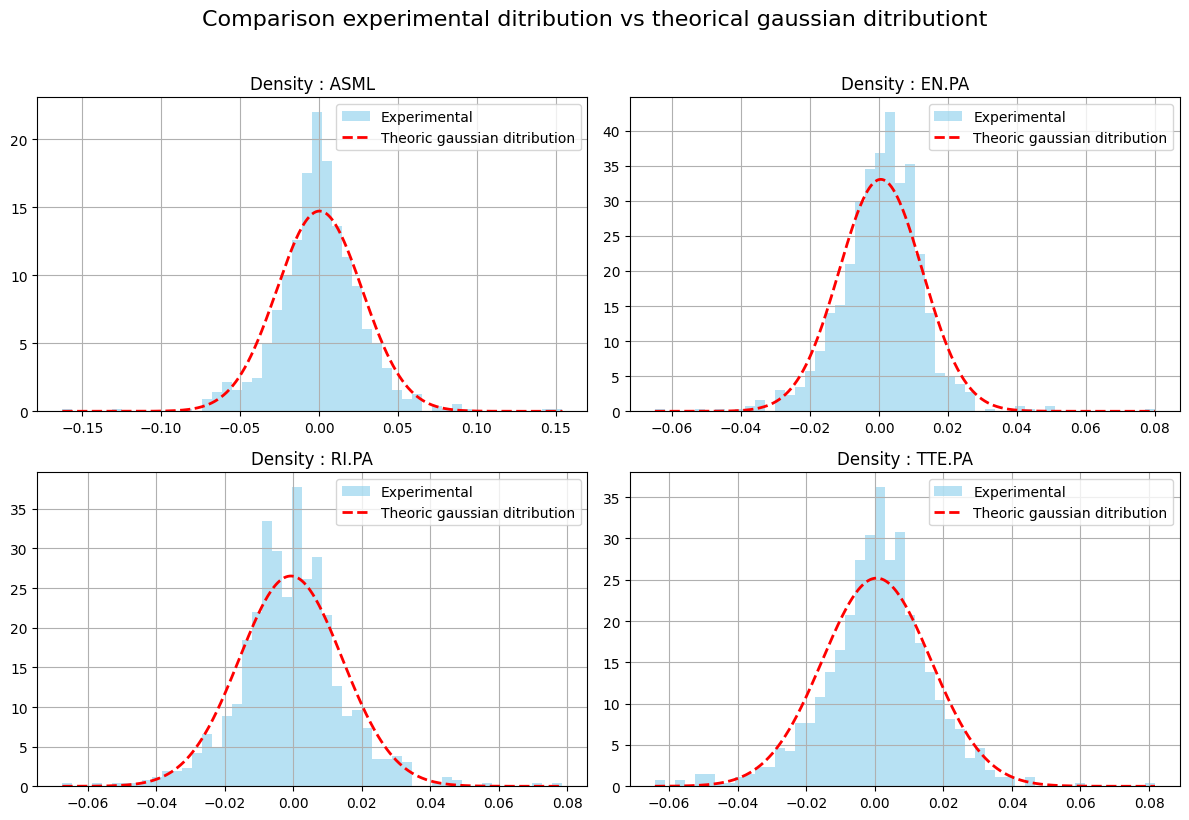

In [83]:
#Plot the gaussians for evry underlying asset
n = len(returns.columns)
n_cols = 2
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(returns.columns):
    r = returns[col].dropna()
    mu, sigma = r.mean(), r.std()
    
    # Histogram of returns
    axes[i].hist(r, bins=50, density=True, alpha=0.6, color='skyblue', label="Experimental")

    # Theoritical gaussian curb
    x = np.linspace(r.min(), r.max(), 500)
    axes[i].plot(x, norm.pdf(x, mu, sigma), 'r--', lw=2, label="Theoric gaussian ditribution")

    axes[i].set_title(f"Density : {col}")
    axes[i].legend()
    axes[i].grid(True)

# Delete empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Comparison experimental ditribution vs theorical gaussian ditributiont", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


We can see that the empirical data does not fit very well with the gaussian distribution. We will plot the QQ-plots to see if there are fat tails.

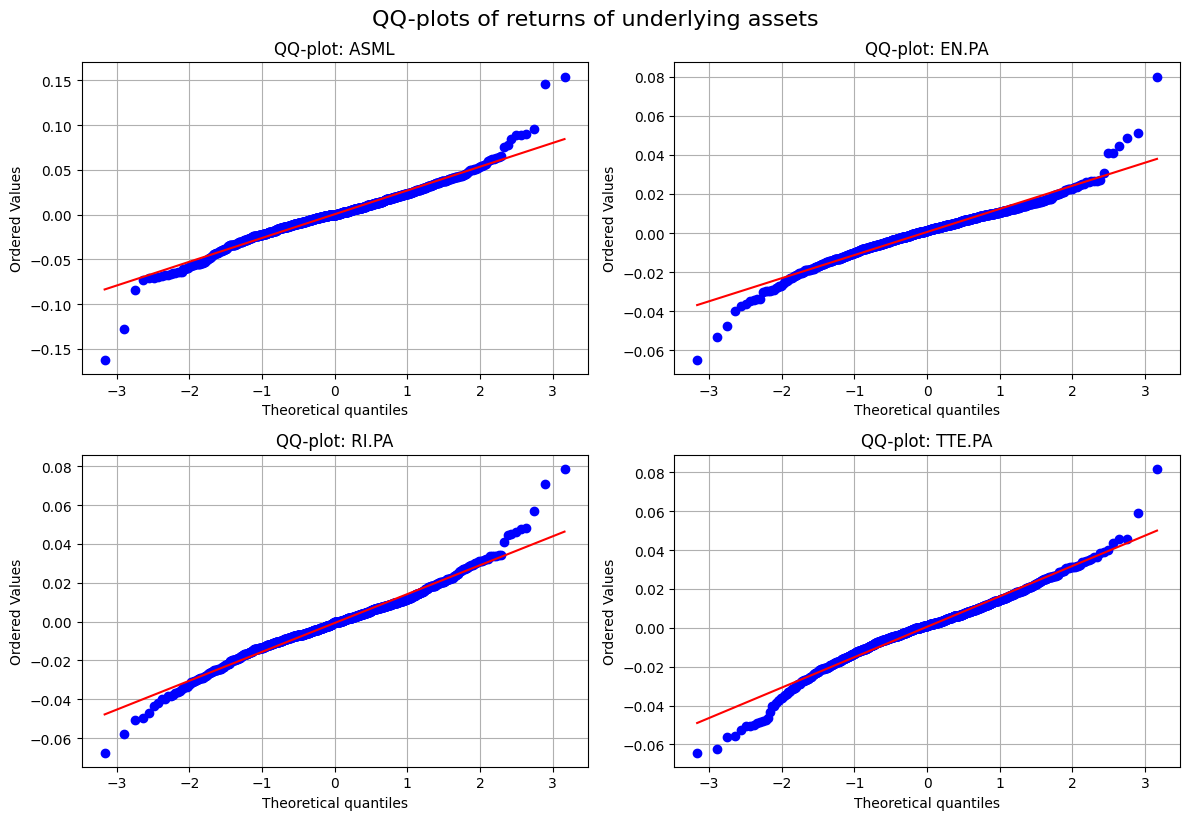

In [84]:
# Number of underlying assets
cols = returns.columns
n = len(cols)

# For the subplot
n_cols = 2
n_rows = int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    stats.probplot(returns[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"QQ-plot: {col}")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.suptitle("QQ-plots of returns of underlying assets", fontsize=16, y=1.02)
plt.show()


We can see that outiside $[-2,2]$, we have important deviation from gaussian ditribution, so we have to adapt to a fat tail model. We also have a lot of observated values in the middle, near 0. We will look at the krutosis and skewess parameters to look at the fat tails and the asymetry.

In [85]:
for col in returns.columns:
    r = returns[col].dropna()
    k = stats.kurtosis(r, fisher=False)  # if > 3 → leptokurtique
    s = stats.skew(r)
    print(f"{col} → Kurtosis : {k:.2f} | Skewness : {s:.2f}")


ASML → Kurtosis : 7.15 | Skewness : 0.02
EN.PA → Kurtosis : 7.28 | Skewness : -0.09
RI.PA → Kurtosis : 5.44 | Skewness : 0.18
TTE.PA → Kurtosis : 5.09 | Skewness : -0.31


## Statistical Analysis of Returns: Skewness and Kurtosis

To better understand the statistical properties of the underlying assets’ returns, we compute the skewness and kurtosis for each stock in the basket:

| Ticker   | Skewness | Kurtosis |
|----------|----------|----------|
| ASML     |  0.02    |  7.15    |
| EN.PA    | -0.09    |  7.28    |
| RI.PA    |  0.18    |  5.44    |
| TTE.PA   | -0.31    |  5.09    |

**Interpretation:**

- **Kurtosis**: All assets exhibit **excess kurtosis**, with values significantly greater than 3, indicating **fat tails** and a higher probability of extreme returns compared to the normal distribution. This is a common feature in financial return series and must be accounted for in pricing and risk simulations.  
  - ASML and EN.PA show particularly **high kurtosis (>7)**, suggesting they are more prone to large deviations or shocks.

- **Skewness**: 
  - The skewness values are relatively **close to 0**, indicating mild asymmetry.
  - TTE.PA and EN.PA have slightly **negative skewness**, suggesting **mild left-tail risk** (more frequent large negative returns).
  - RI.PA has a slightly **positive skew**, but the effect is small.
  - Overall, **none of the assets show strong directional asymmetry**, but the **non-Gaussian nature (fat tails)** is clearly present and justifies using **Student-t** or **non-normal models** for simulation.

This analysis supports the use of more robust models than the standard geometric Brownian motion, such as the Student-t distribution, to better capture the empirical behavior of asset returns.


In [86]:
#returns
for tik in tickers:
    mean_returns = returns[tik].mean()
    print(f" Mean return for {tik} : {mean_returns}")

 Mean return for TTE.PA : 0.0005377774294614273
 Mean return for ASML : 0.00035456832336320046
 Mean return for EN.PA : 0.000528810849431644
 Mean return for RI.PA : -0.0007433502727684818


We can see that the returns are very close to 0, thus we can assume that the returns are centered -> we add floc=0 in stat.t (to avoid misleading volatility in the fat tail)

The following code enable us to determine the parameters of th t-Student ditribution.

In [87]:
# Dict to save parameters for the t-distribution
t_params = {}

for ticker in tickers:
    ret = returns[ticker].dropna().values
    
    if len(ret) == 0:
        print(f"No returns for {ticker}, skipping...")
        continue
    
    # Student-t calibration with loc forced to 0
    nu_hat, loc_hat, sigma_hat = stats.t.fit(ret, floc=0)
    
    print(f"{ticker} - Student-t calibration:")
    print(f"  degrees of freedom (nu) = {nu_hat:.2f}")
    print(f"  location shift (fixed to 0) = {loc_hat:.4f}")
    print(f"  daily volatility (scale) = {sigma_hat:.4f}")
    print(f"  annualized volatility = {sigma_hat * np.sqrt(252):.4f}")
    print("-" * 40)
    
    t_params[ticker] = {
        'nu': nu_hat,
        'loc': loc_hat,
        'scale_daily': sigma_hat,
        'scale_annual': sigma_hat * np.sqrt(252)
    }


TTE.PA - Student-t calibration:
  degrees of freedom (nu) = 4.81
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0123
  annualized volatility = 0.1954
----------------------------------------
ASML - Student-t calibration:
  degrees of freedom (nu) = 4.32
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0201
  annualized volatility = 0.3187
----------------------------------------
EN.PA - Student-t calibration:
  degrees of freedom (nu) = 5.22
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0094
  annualized volatility = 0.1492
----------------------------------------
RI.PA - Student-t calibration:
  degrees of freedom (nu) = 4.87
  location shift (fixed to 0) = 0.0000
  daily volatility (scale) = 0.0117
  annualized volatility = 0.1856
----------------------------------------


Then we want to see if the t-Student distribution is a good fitting for our problem. The following code plots the t-Student distribution with the empirical data.

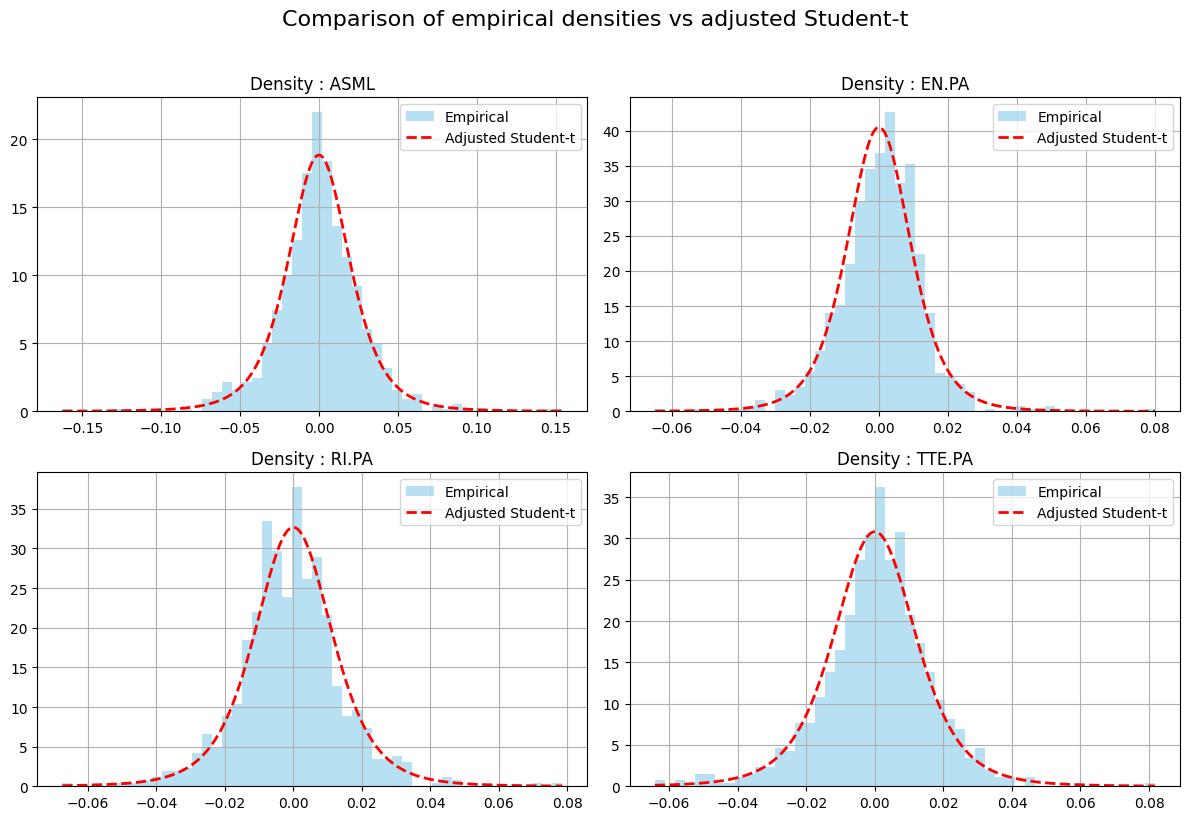

In [88]:
# Calibrated parameters : number of freedom (nu) and scale (daily vol)
student_params = {
    "TTE.PA": {"nu": 4.83, "scale": 0.0123},
    "ASML": {"nu": 4.32, "scale": 0.0200},
    "EN.PA": {"nu": 5.24, "scale": 0.0094},
    "RI.PA": {"nu": 4.84, "scale": 0.0116}
}

# Plot the curbs for each asset
n = len(returns.columns)
n_cols = 2
n_rows = int(np.ceil(n / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(returns.columns):
    r = returns[col].dropna()

    nu = student_params[col]["nu"]
    scale = student_params[col]["scale"]
    loc = 0  # centered, as supposed in the calibration

    # Histogram of returns
    axes[i].hist(r, bins=50, density=True, alpha=0.6, color='skyblue', label="Empirical")

    # Adjusted Student-t density
    x = np.linspace(r.min(), r.max(), 500)
    pdf_student = t.pdf(x, df=nu, loc=loc, scale=scale)
    axes[i].plot(x, pdf_student, 'r--', lw=2, label="Adjusted Student-t")

    axes[i].set_title(f"Density : {col}")
    axes[i].legend()
    axes[i].grid(True)

# Delete empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Comparison of empirical densities vs adjusted Student-t", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


We can see that the t-Student fitting is far better than the gaussian fitting, we will use use it for the following of the project. However, we still want to be sure that the t-Student distribution fits well with the QQ-plots.

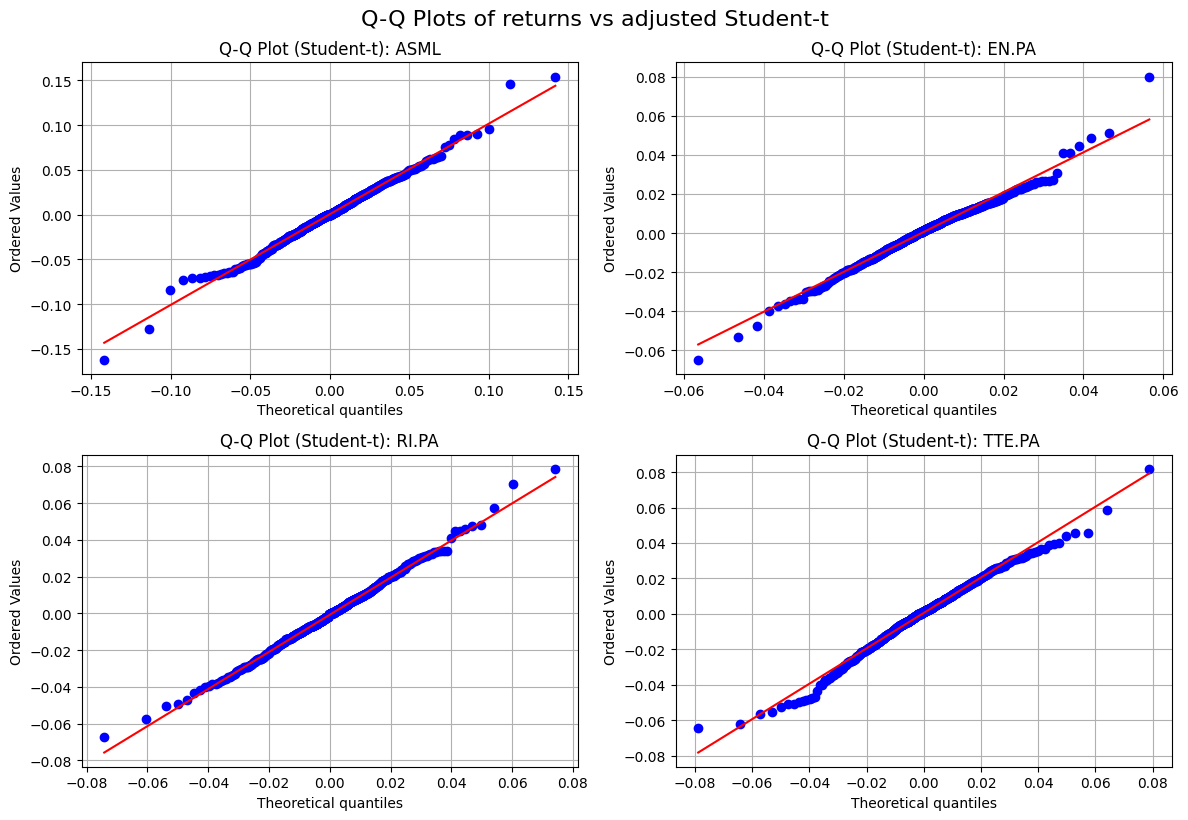

In [89]:
# List of underlying assets
cols = returns.columns
n = len(cols)

# Organisation of subplots
n_cols = 2
n_rows = int(np.ceil(n / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

# Generation of Q-Q plots
for i, col in enumerate(cols):
    r = returns[col].dropna()
    nu = student_params[col]["nu"]
    scale = student_params[col]["scale"]
    loc = 0  # centered

    stats.probplot(r, dist="t", sparams=(nu, loc, scale), plot=axes[i])
    axes[i].set_title(f"Q-Q Plot (Student-t): {col}")
    axes[i].grid(True)

# Delete empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.suptitle("Q-Q Plots of returns vs adjusted Student-t", fontsize=16, y=1.02)
plt.show()


As we can see, the points are on the line or close to the line, it is far better than the gaussian ditribution. Then, we will use a Student-t distribution for the following.

In [90]:
# Only keep 'close' columns
close_data = data['Close']

# take the last price 
spot_prices = close_data.iloc[-1]

print(spot_prices)
spot_prices.keys()

Ticker
ASML      801.390015
EN.PA      38.400002
RI.PA      84.599998
TTE.PA     52.099998
Name: 2025-06-30 00:00:00, dtype: float64


Index(['ASML', 'EN.PA', 'RI.PA', 'TTE.PA'], dtype='object', name='Ticker')

## Monte Carlo Simulation for Pricing

To estimate the fair value of the structured product and analyze its risk profile, we will use a **Monte Carlo simulation**.

Monte Carlo methods allow us to model the future evolution of the underlying assets by generating a large number of stochastic price paths. These simulated trajectories will incorporate key market features such as:
- the empirical correlation structure between assets,
- fat tails and volatility clustering (via Student-t innovations),
- and optionally, time-varying covariance matrices (e.g., using a Wishart process).

Using these simulated paths, we will compute the product's cash flows under different scenarios, and then average them (discounted if needed) to obtain the estimated price. We will also extract statistics such as:
- the probability of early redemption (autocall),
- the average total payout,
- the distribution of returns for the investor.

This approach is particularly well-suited for path-dependent or exotic products where no closed-form pricing formula is available.


In [91]:
#we use the data of the past 3 years
recent_vol = df_vols[["ticker", "vol"]].set_index('ticker')

In [92]:
def get_vol_from_df(df, ticker):
    try:
        return df.loc[ticker, 'vol']
    except KeyError:
        print(f"Volatility not found for {ticker} in the DataFrame.")
        return None

for ticker in spot_prices.keys():
    sigma_recent = get_vol_from_df(recent_vol, ticker)
    
    if sigma_recent is None :
        print(f"Skip {ticker} because the vol was missing")
        continue

First, we implement the simplest Monte Carlo simualtsimulation possible, based on a normal ditribution. 

In [93]:
def monte_carlo_paths(S0, mu, sigma, T, N, M):
    dt = T / N
    paths = np.zeros((M, N + 1))
    paths[:, 0] = S0
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        paths[:, t] = paths[:, t-1] * np.exp((mu - 0.5 * sigma**2)*dt + sigma * np.sqrt(dt) * Z)
    return paths

<Figure size 1200x500 with 0 Axes>

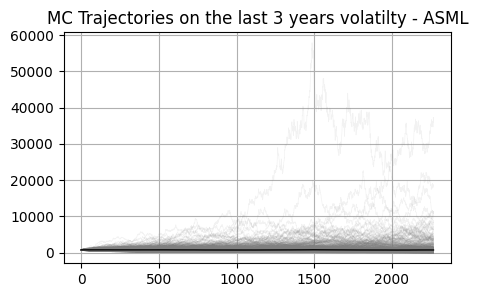

<Figure size 1200x500 with 0 Axes>

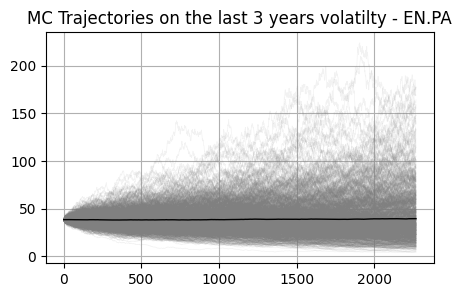

<Figure size 1200x500 with 0 Axes>

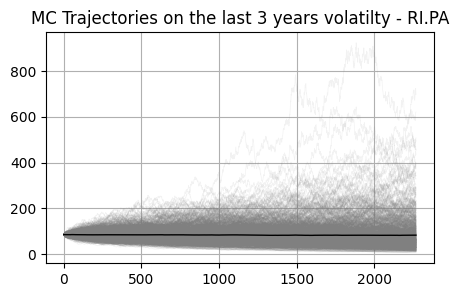

<Figure size 1200x500 with 0 Axes>

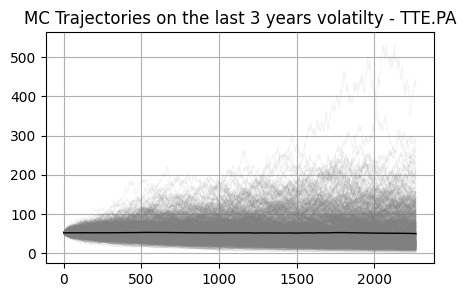

In [94]:
# simualtion and plot for each period of time
for ticker in spot_prices.keys():
    plt.figure(figsize=(12,5))

    # Trajectories based on last year volatility
    paths_recent = monte_carlo_paths(spot_prices.loc[ticker], mu, recent_vol.loc[ticker, 'vol'], T, N_steps, M)

    plt.figure(figsize=(5, 3))
    for i in range(M):
        plt.plot(paths_recent[i], lw=0.5, alpha=0.1, color='gray')
    mean_path = paths_recent.mean(axis=0)
    plt.plot(mean_path, color='black', lw=1, label='Mean trajectory')
    plt.title(f"MC Trajectories on the last 3 years volatilty - {ticker}")
    plt.grid(True)
    plt.show()


We now implement a more advanced Monte Carlo simulation. The distribution is no longer Gaussian, but follows a Student's t-distribution, which better captures the heavy tails observed in real financial returns.

In [95]:
# Ajustement sur les rendements
df, loc, scale = t.fit(returns)
nu = {}

for ticker in spot_prices.index:
    returns = log_returns[ticker].dropna().values
    df, _, _ = t.fit(returns)
    nu[ticker] = df

nu = pd.Series(nu)

In [96]:
def monte_carlo_paths_tstudent_multivariate(S0, mu, sigma, T, N, M, nu):
    """
    Simulates multivariate asset paths with t-Student innovations per asset.

    Args:
        S0 (array-like): Initial asset prices, shape (d,)
        mu (array-like): Annualized drift of the assets, shape (d,)
        sigma (array-like): Annualized volatilities of the assets, shape (d,)
        T (float): Total time horizon in years
        N (int): Number of time steps
        M (int): Number of Monte Carlo simulations
        nu (array-like): Degrees of freedom of the t-Student distribution per asset, shape (d,)

    Returns:
        np.ndarray: Simulated price paths, shape (M, N+1, d)
    """

    S0 = np.array(S0)
    mu = np.array(mu)
    sigma = np.array(sigma)
    nu = np.array(nu)

    d = len(S0)
    assert mu.shape == sigma.shape == nu.shape == (d,), "mu, sigma et nu need a shape (d,)"
    
    dt = T / N
    paths = np.zeros((M, N + 1, d))
    paths[:, 0, :] = S0  # initial prices

    for j in range(d):
        Z = np.random.standard_t(df=nu[j], size=(M, N))  # t-Student with df related to the j-th asset
        scale = np.sqrt((nu[j] - 2) / nu[j])
        returns = mu[j] * dt + sigma[j] * scale * np.sqrt(dt) * Z
        log_paths = np.cumsum(returns, axis=1)
        paths[:, 1:, j] = S0[j] * np.exp(log_paths)

    return paths


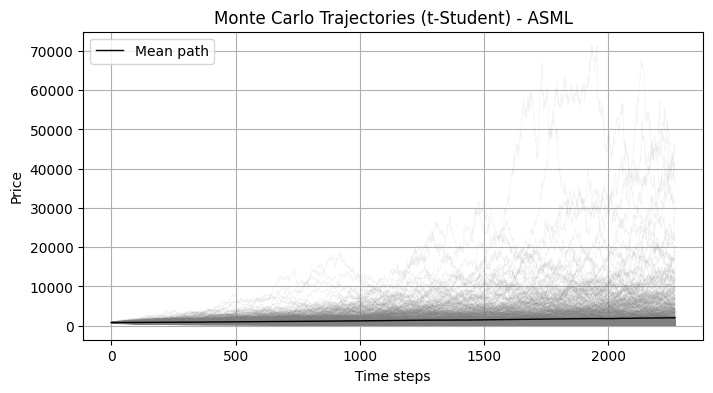

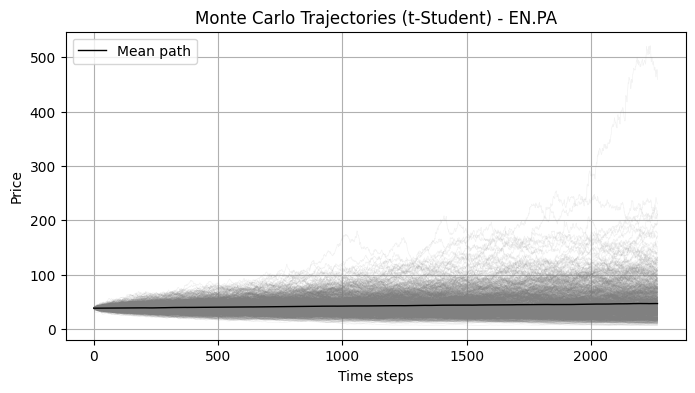

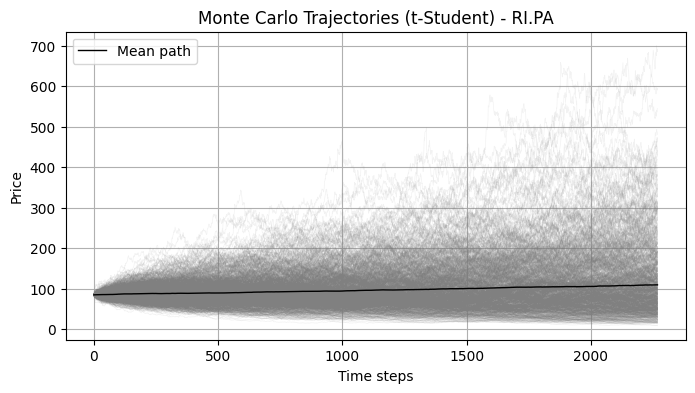

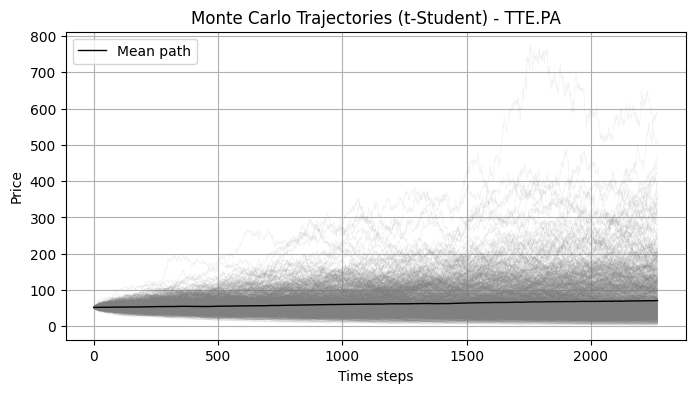

In [97]:
for i, ticker in enumerate(spot_prices.index):
    S0_ = [spot_prices[ticker]]            # shape (1,)
    mu_ = [mu]                             # constant drift
    sigma_ = [recent_vol.loc[ticker, 'vol']]
    nu_ = [nu.loc[ticker]]

    paths_recent = monte_carlo_paths_tstudent_multivariate(S0_, mu_, sigma_, T, N_steps, M, nu_)
    
    plt.figure(figsize=(8, 4))
    for j in range(M):
        plt.plot(paths_recent[j, :, 0], lw=0.5, alpha=0.1, color='gray')
    plt.plot(paths_recent[:, :, 0].mean(axis=0), lw=1, color='black', label='Mean path')
    plt.title(f"Monte Carlo Trajectories (t-Student) - {ticker}")
    plt.xlabel("Time steps")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()


To further improve the model, we implemented a correlated Monte Carlo simulation based on the previously introduced Student's t-distribution.

In [98]:
def monte_carlo_correlated_multivariate_tstudent(S0, mu, sigma, T, N, M, nu_vec, corr_matrix):
    """
    Simulates correlated asset paths via multivariate Student-t distribution.

    - S0: vector of initial prices (shape: d,)
    - mu: drift vector (shape: d,)
    - sigma: volatilities (shape: d,)
    - nu_vec: Student-t degrees of freedom vector (shape: d,)
    - corr_matrix: empirical correlation matrix (d x d)
    """

    dt = T / N
    d = len(S0)

    # Décomposition de Cholesky de la matrice de corrélation
    L = np.linalg.cholesky(corr_matrix)

    # Initialisation du tableau des trajectoires
    paths = np.zeros((M, N + 1, d))
    paths[:, 0, :] = S0

    # Simulation pas par pas
    for t_step in range(1, N + 1):
        # Générer des chocs Student-t indépendants pour chaque actif
        Z_indep = np.array([
            t.rvs(df=nu_vec[i], size=M) * np.sqrt((nu_vec[i] - 2) / nu_vec[i])
            for i in range(d)
        ]).T  # shape: (M, d)

        # Introduire la corrélation
        Z_corr = Z_indep @ L.T  # shape: (M, d)

        # Calculer les multiplicateurs exponentiels pour chaque actif
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z_corr

        # Mise à jour des log-prix
        log_returns = drift + diffusion
        paths[:, t_step, :] = paths[:, t_step - 1, :] * np.exp(log_returns)

    return paths


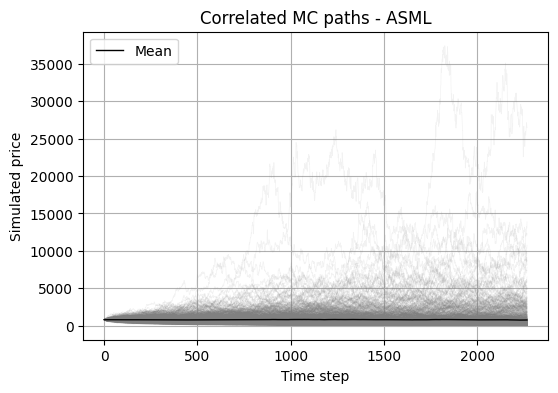

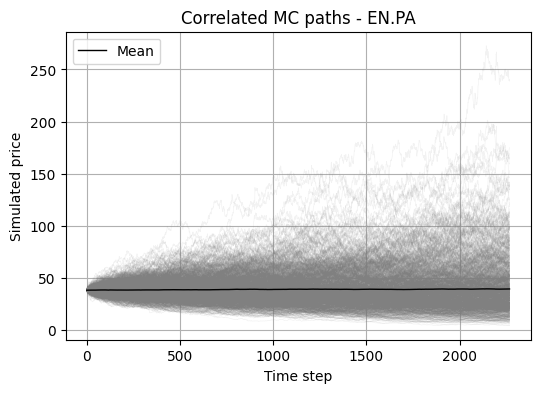

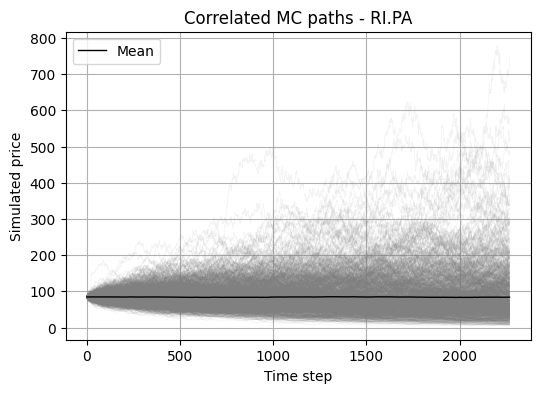

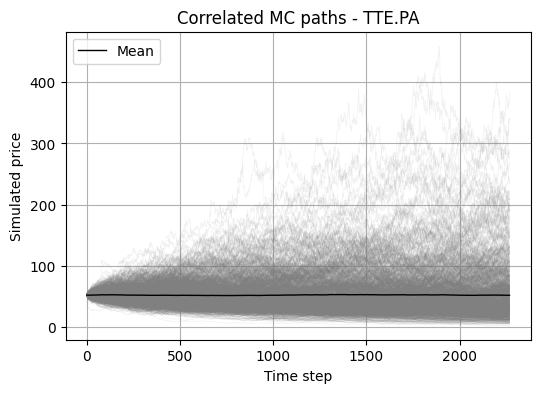

In [99]:
S0 = spot_prices.values             # shape (d,)
mu_vec = np.full_like(S0, mu)       # même drift pour tous (ou vectorisé)
sigma_vec = recent_vol.values.flatten()
nu_vec = nu[spot_prices.index].values
corr_matrix = correlation_matrix.values

paths = monte_carlo_correlated_multivariate_tstudent(
    S0, mu_vec, sigma_vec, T, N_steps, M, nu_vec, corr_matrix
)

tickers = spot_prices.index.tolist()  # ['ASML', 'EN.PA', 'RI.PA', 'TTE.PA']

for i, ticker in enumerate(tickers):
    plt.figure(figsize=(6, 4))
    plt.plot(paths[:, :, i].T, lw=0.5, alpha=0.1, color='gray')
    plt.plot(paths[:, :, i].mean(axis=0), color='black', lw=1, label='Mean')
    plt.title(f"Correlated MC paths - {ticker}")
    plt.xlabel("Time step")
    plt.ylabel("Simulated price")
    plt.grid(True)
    plt.legend()
    plt.show()



### Quasi Monte Carlo

To enhance the efficiency and accuracy of our Monte Carlo simulations, we used Quasi-Monte Carlo (QMC) methods. Unlike standard Monte Carlo, which relies on random sampling, QMC uses low-discrepancy sequences (such as Sobol sequences) to more uniformly explore the sample space, leading to faster convergence and reduced variance in the estimated results.

In [100]:
paths_recent_QMC= monte_carlo_paths_tstudent_multivariate(S0_, mu_, sigma_, T, N_steps, M, nu_)

/var/folders/k6/tkt2xb056ksgrwnd0n53bzgw0000gn/T/ipykernel_80251/3049525458.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nu_ = [nu[i]]  # i entre 0 et 3 ici


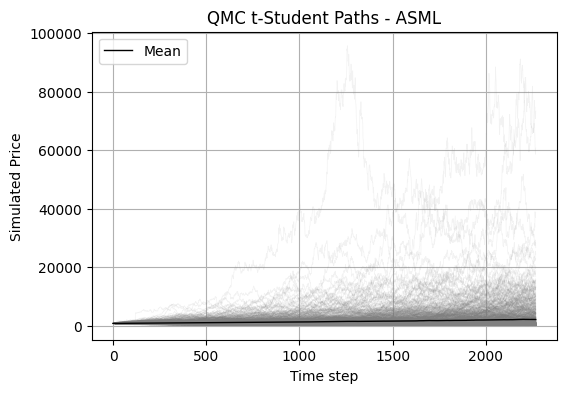

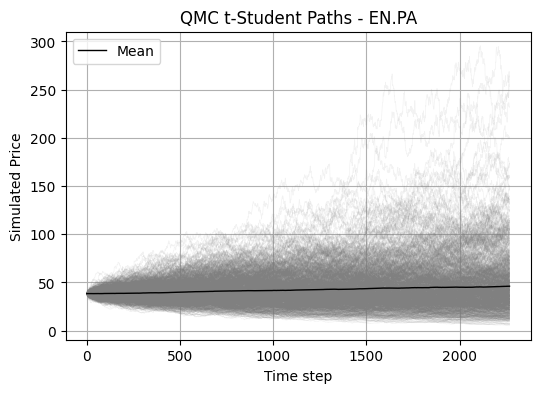

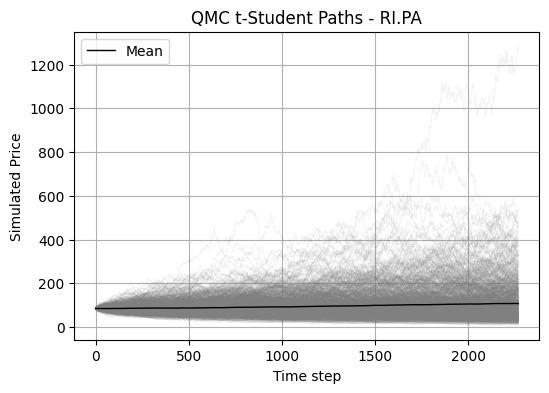

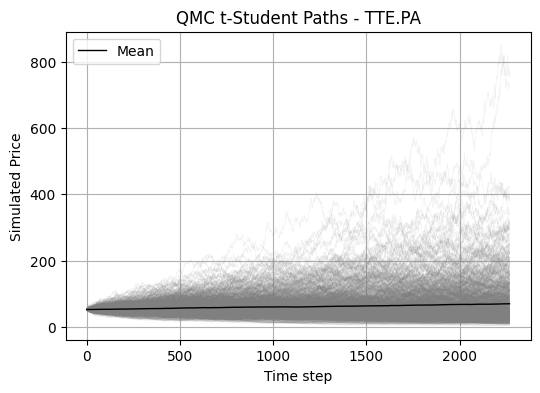

In [101]:
tickers = spot_prices.index.tolist()

for i, ticker in enumerate(tickers):
    S0_ = [spot_prices.loc[ticker]]
    mu_ = [mu]
    sigma_ = [recent_vol.loc[ticker, 'vol']]
    nu_ = [nu[i]]  # i entre 0 et 3 ici
    
    paths_recent_QMC = monte_carlo_paths_tstudent_multivariate(S0_, mu_, sigma_, T, N_steps, M, nu_)

    plt.figure(figsize=(6, 4))
    for k in range(M):
        plt.plot(paths_recent_QMC[k, :, 0], lw=0.5, alpha=0.1, color='gray')
    plt.plot(paths_recent_QMC[:, :, 0].mean(axis=0), color='black', lw=1, label='Mean')
    plt.title(f"QMC t-Student Paths - {ticker}")
    plt.xlabel("Time step")
    plt.ylabel("Simulated Price")
    plt.grid(True)
    plt.legend()
    plt.show()


### Correlation evolution (Wishart process)

We use a Wishart process to model the dynamics of the covariance matrix of asset returns over time. Unlike models with constant volatility and correlation, the Wishart process allows us to capture the time-varying nature of risk and interdependence between multiple assets. This is especially useful in a multivariate framework, where changes in volatility and correlations across assets significantly affect pricing, risk assessment, and portfolio optimization.

In [102]:
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
window = 21
cov_matrices = [log_returns.iloc[i-window:i].cov().values for i in range(window, len(log_returns))]
cov_matrices = np.array(cov_matrices)  # shape (num_windows, d, d)
mean_cov = np.mean(cov_matrices, axis=0)*252
vol_cov_entries = np.std(cov_matrices, axis=0)*np.sqrt(252)

### What is **κ** (kappa), and why do we estimate it?

In the Wishart stochastic volatility model, **κ (kappa)** is a key parameter that controls the **speed of mean reversion** of the covariance matrix process toward its long-term average **Θ (Theta)**.

More precisely, the Wishart process evolves according to the stochastic differential equation:

$$
dX_t = \kappa (\Theta - X_t)\, dt + \sqrt{X_t}\, dW_t\, \sqrt{X_t}
$$

Where:
- \( X_t \) is the instantaneous covariance matrix,  
- \( \Theta \) is the long-term mean covariance matrix,  
- \( \kappa \) determines how fast the process reverts to \( \Theta \),  
- \( dW_t \) is a matrix Brownian motion.

Estimating **κ** is important because it determines the **persistence of volatility**:
- A **high κ** leads to fast reversion to the mean → short memory of shocks,  
- A **low κ** means volatility changes slowly and has long memory.

We estimate κ using historical data, typically by:
- Computing a time series of empirical covariance matrices (e.g., using rolling windows),  
- Fitting the Wishart model to these matrices using **least squares**, **moment matching**, or **maximum likelihood**,  
- Choosing the value of κ that best replicates the observed dynamics.

Estimating κ allows us to simulate realistic paths for the covariance matrix, which is essential in multi-asset modeling, risk management, and derivative pricing.


In [103]:
def estimate_kappa(cov_matrices, dt):
    """
    Estimates kappa (mean reversion speed) for a Wishart process
    via an AR(1) regression on each element of the covariance matrix.

    Args:
        cov_matrices (np.ndarray): array of shape (T, d, d) containing historical covariance matrices
        dt (float): time step between each matrix (e.g., 1/252 for daily data)

    Returns:
        kappa_est (float): average estimate of kappa over all elements (i, j)
    """
    T, d, _ = cov_matrices.shape
    kappas = []

    # Perform the regression for each element of the matrix
    for i in range(d):
        for j in range(d):
            X_t = cov_matrices[:-1, i, j]    # covariance at time t
            X_tp1 = cov_matrices[1:, i, j]   # covariance at time t + dt
            delta_X = X_tp1 - X_t

            # Model: delta_X = kappa * (Theta - X_t) * dt
            # => delta_X / dt = kappa * (Theta - X_t)
            # Theta ~ empirical mean of X (stationarity assumption)
            Theta = np.mean(cov_matrices[:, i, j])

            y = delta_X / dt
            X = (Theta - X_t).reshape(-1, 1)

            # Linear regression y = kappa * X
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            kappa_ij = reg.coef_[0]
            kappas.append(kappa_ij)

    kappa_est = np.mean(kappas)
    return kappa_est

In [104]:
kappa_est = estimate_kappa(cov_matrices, dt=1/252)
print("Estimation moyenne de kappa :", kappa_est)


Estimation moyenne de kappa : 8.389235460096414


### Wishart Process and Simulation

The **Wishart process** models the stochastic evolution of a covariance matrix \(X_t\) over time, useful for capturing time-varying volatility and correlations in multiple assets.

It follows the SDE:
\[
dX_t = \kappa (\Theta - X_t) dt + \sqrt{X_t} dW_t G + G^\top dW_t^\top \sqrt{X_t}
\]
where:
- \(\Theta\) is the long-term mean covariance,
- \(\kappa\) is the mean-reversion speed,
- \(G\) is the volatility matrix,
- \(dW_t\) is a matrix Brownian motion,
- \(\sqrt{X_t}\) is the matrix square root.

---

The function `simulate_wishart_process` simulates this process discretely:
- Starts from initial matrix \(X_0\),
- At each step, adds drift pulling \(X_t\) toward \(\Theta\),
- Adds diffusion based on Brownian noise and \(G\),
- Ensures symmetry and positive definiteness by projection.

Returns simulated covariance matrices over time, useful for multivariate volatility modeling.


In [105]:
def simulate_wishart_process(X0, Theta, kappa, G, dt, N_steps):
    """
    Simulates a discrete Wishart process.

    Args:
        X0 (np.ndarray): initial matrix (d x d symmetric positive definite)
        Theta (np.ndarray): long-term mean matrix (d x d)
        kappa (float): mean reversion speed
        G (np.ndarray): volatility matrix (d x d)
        dt (float): time step
        N_steps (int): number of iterations

    Returns:
        X_paths (np.ndarray): process trajectories of shape (N_steps+1, d, d)
    """


    d = X0.shape[0]
    X = X0.copy()
    X_paths = np.zeros((N_steps + 1, d, d))
    X_paths[0] = X0

    for t in range(1, N_steps + 1):
        # Matrix Brownian noise dW
        dW = np.random.normal(0, np.sqrt(dt), size=(d, d))
        
        # Diffusion terms
        sqrt_X = np.linalg.cholesky(X)  # Cholesky for positive definite square root
        diffusion = sqrt_X @ dW @ G + G.T @ dW.T @ sqrt_X

        # Deterministic drift term
        drift = kappa * (Theta - X) * dt
        
        # Discrete update
        X = X + drift + diffusion
        
        # Ensure X remains symmetric
        X = (X + X.T) / 2
        
        # Small correction if not positive definite (projection via eigenvalues)
        eigvals, eigvecs = np.linalg.eigh(X)
        eigvals_clipped = np.clip(eigvals, 1e-8, None)
        X = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

        X_paths[t] = X

    return X_paths


**Parameters of the Wishart process:**

- `X0`: initial covariance matrix (here, the empirical mean `mean_cov`)  
- `Theta`: long-term mean covariance matrix (also `mean_cov` here)  
- `G`: volatility matrix for the covariance process (`vol_cov_entries`)  
- `dt`: discrete time step  
- `N_steps`: number of iterations (time steps)  
- `kappa`: mean reversion speed  
```


In [106]:
print("X0 diag:", np.diag(mean_cov))
print("Theta diag:", np.diag(mean_cov))
print("G diag:", np.diag(vol_cov_entries))
print("dt =",dt)
print("N_step =", N_steps)
print("kappa =", kappa_est)

X0 = mean_cov
Theta = mean_cov
G = vol_cov_entries

X0 diag: [0.19835253 0.03822281 0.05876227 0.06319614]
Theta diag: [0.19835253 0.03822281 0.05876227 0.06319614]
G diag: [0.00815176 0.00133408 0.00216881 0.00280444]
dt = 0.003968253968253968
N_step = 2268
kappa = 8.389235460096414


This plot shows the evolution over time of the off-diagonal elements of the covariance matrix simulated by the Wishart process. Each subplot corresponds to the covariance between a pair of assets, illustrating how their joint variability changes dynamically according to the estimated mean-reversion speed `kappa` and the stochastic fluctuations introduced in the simulation.

kappa estimate: 8.3892


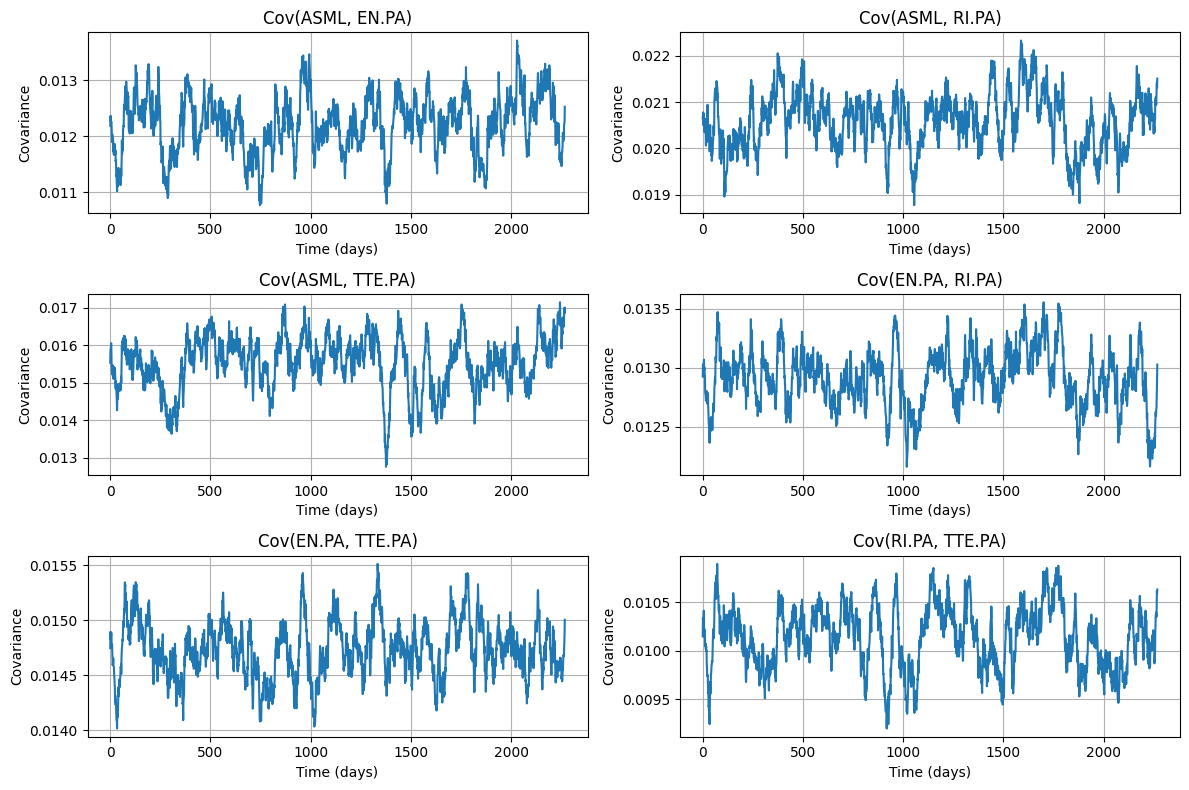

In [107]:
kappa = estimate_kappa(cov_matrices, dt)
print(f"kappa estimate: {kappa:.4f}")

X_paths = simulate_wishart_process(X0, Theta, kappa, G, dt, N_steps)
asset_names = correlation_matrix.columns.tolist()

d = len(asset_names)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axs = axs.flatten()

plot_idx = 0
for i in range(d):
    for j in range(i + 1, d):
        axs[plot_idx].plot(X_paths[:, i, j])
        axs[plot_idx].set_title(f"Cov({asset_names[i]}, {asset_names[j]})")
        axs[plot_idx].set_xlabel("Time (days)")
        axs[plot_idx].set_ylabel("Covariance")
        axs[plot_idx].grid(True)
        plot_idx += 1

plt.tight_layout()
plt.show()



In [108]:
S0 = close_prices.iloc[-1].values  #initial prices of the underlying assets (shape: d,)
mu_multi = np.full(len(S0), mu) # adapt the mu as a vector 

This function simulates multivariate asset price paths using a time-varying covariance matrix process (`X_paths`) and heavy-tailed t-Student shocks.

- **Inputs**:
  - `S0`: initial prices of the assets (vector of length d).
  - `X_paths`: sequence of covariance matrices over time (shape `(N_steps+1, d, d)`).
  - `mu`: vector of drift rates for each asset.
  - `nu`: degrees of freedom for the t-Student distribution (controls tail heaviness).
  - `dt`: time step size.
  - `N_steps`: number of time steps.

- **Process**:
  - At each time step, the covariance matrix `cov_t` is extracted and decomposed via Cholesky (`L`) to model correlations.
  - If `cov_t` is not positive definite, it is corrected by eigenvalue clipping to ensure a valid Cholesky decomposition.
  - A vector `Z` of t-Student distributed random variables (with degrees of freedom `nu`) is generated to introduce stochastic shocks with heavier tails than Gaussian.
  - The diffusion increment `dW` is computed as the product of `L`, `Z`, and the square root of the time step.
  - Instantaneous volatilities are extracted from the diagonal of the covariance matrix and annualized.
  - The log-price increment is the sum of drift (`mu * dt`) and diffusion (`dW`).
  - Asset prices are updated by exponentiating the log-price increments (geometric Brownian motion style).

- **Outputs**:
  - `paths`: simulated asset prices over time.
  - `vols`: annualized instantaneous volatilities over time.


In [109]:
def simulate_multivariate_asset_paths(S0, X_paths, mu, nu, dt, N_steps):
    d = len(S0)
    paths = np.zeros((N_steps + 1, d))
    vols = np.zeros((N_steps + 1, d))  # volatilité annualisée instantanée
    paths[0] = S0
    
    sqrt_dt = np.sqrt(dt)  # calcul une seule fois pour annualisation
    
    for t in range(1, N_steps + 1):
        cov_t = X_paths[t]
        
        try:
            L = np.linalg.cholesky(cov_t)
        except np.linalg.LinAlgError:
            cov_t = (cov_t + cov_t.T) / 2
            eigvals, eigvecs = np.linalg.eigh(cov_t)
            eigvals_clipped = np.clip(eigvals, 1e-8, None)
            cov_t = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
            L = np.linalg.cholesky(cov_t)

       # Z = np.random.normal(size=d)
        Z = np.random.standard_t(df=nu, size=d)
        dW = L @ Z * sqrt_dt

        sigma_diag = np.sqrt(np.diag(cov_t))  # volatilité sur dt (ex: journalière)
        vols[t] = sigma_diag / sqrt_dt       # annualisation : diviser par sqrt(dt)

        drift = mu * dt
        diffusion = dW

        paths[t] = paths[t - 1] * np.exp(drift + diffusion)

    return paths, vols


In [ ]:
M = 1000
all_paths = np.zeros((M, N_steps + 1, len(S0)))
volat = np.zeros((M, N_steps + 1, len(S0)))

for i in tqdm(range(M)):
    all_paths[i] , volat[i] = simulate_multivariate_asset_paths(S0, X_paths, mu, nu, dt, N_steps)

log_returns_total = np.log(all_paths[:, -1, :] / all_paths[:, 0, :])  # shape: (num_paths, num_assets)
vol_empirique_10ans = np.std(log_returns_total, axis=0)
print("Observed volatility on the last 10 years, per asset :", vol_empirique_10ans)
#

T = 10  # durée totale en années
vol_annuelle_estimee = vol_empirique_10ans / np.sqrt(T)
print("Estimate of the annual volatility  :", vol_annuelle_estimee)

100%|██████████| 1000/1000 [00:36<00:00, 27.63it/s]

Volatilité empirique 10 ans par actif : [1.76892963 0.76521542 0.96006906 0.96601263]
Volatilité annualisée estimée : [0.55938466 0.24198236 0.30360049 0.30548002]


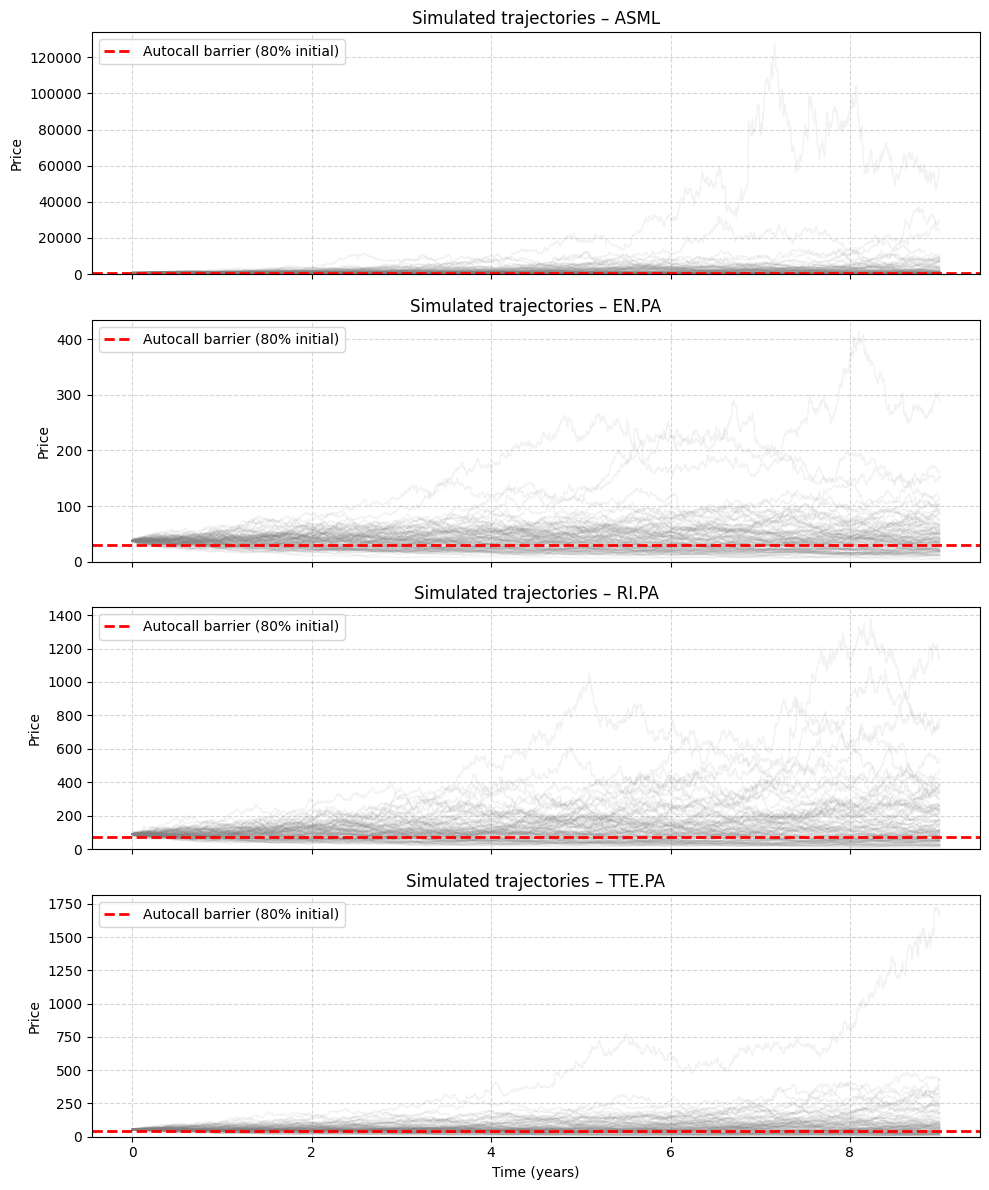

In [ ]:
num_paths_to_plot = 100
num_assets = len(S0)

fig, axes = plt.subplots(num_assets, 1, figsize=(10, 3 * num_assets), sharex=True)

time = np.linspace(0, N_steps * dt, N_steps + 1)

for d_idx in range(num_assets):
    ax = axes[d_idx] if num_assets > 1 else axes
    for i in range(num_paths_to_plot):
        ax.plot(time, all_paths[i, :, d_idx], lw=1, alpha=0.1, color='gray')
    ax.set_title(f"Simulated trajectories – {asset_names[d_idx]}")
    ax.set_ylabel("Price")
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    
    barrier_level = 0.8 * S0[d_idx]
    ax.axhline(y=barrier_level, color='red', linestyle='--', linewidth=2, label=f'Autocall barrier (80% initial)')
    ax.legend()
    
    ax.set_ylim(bottom=0)

axes[-1].set_xlabel("Time (years)")
plt.tight_layout()
plt.show()


# Pricing

This function calculates cash flows for an autocallable financial product based on simulated normalized asset price paths.

  1. For each simulation path, iterate over observation dates:
     - Compute the worst-performing asset price at that date.
     - If worst performance is above the interest barrier, accumulate interest payments for all quarters elapsed.
     - If worst performance exceeds the autocall barrier (from the 4th observation onward), pay back principal plus accrued interest and stop (autocall triggered).
  2. If no autocall triggered by maturity:
     - Check final worst asset performance against the knock-in barrier.
     - If above, full principal is returned.
     - Otherwise, capital loss proportional to worst final asset price.


In [112]:
def calculate_cash_flows(normalized_paths, interest_barrier, autocall_barriers, knock_in_barrier, interest_rate, observation_dates):
    """
    Calculate cash flows for an autocallable product using normalized asset paths.

    Parameters:
    - normalized_paths: np.ndarray (num_paths, num_steps, num_assets), where all paths start at 1.0
    - interest_barrier: float, e.g. 0.9
    - autocall_barriers: list of float, e.g. [0.95, 0.95, ...]
    - knock_in_barrier: float, e.g. 0.6
    - interest_rate: float, e.g. 0.0255 for 2.55%
    - observation_dates: list of integers (indices in the time axis)

    Returns:
    - np.ndarray of shape (num_paths,) with the cash flow per path
    """
    num_paths = normalized_paths.shape[0]
    cash_flows = np.zeros(num_paths)
    end_time = np.zeros(num_paths) 

    autocall_flag = 0

    for path_idx in range(num_paths):
        path = normalized_paths[path_idx, :, :]
        path_cash_flow = 0

        for date_idx, obs_date in enumerate(observation_dates):
            prices = path[obs_date, :]
            worst_perf = np.min(prices)

            
            # 1. If worst performance is above the interest barrier, pay interest for all past quaters
            if worst_perf >= interest_barrier:
                path_cash_flow = interest_rate * 1000  * (date_idx +1)


            # 2. Check if autocall is triggered
            if worst_perf >= autocall_barriers[date_idx] and date_idx >= 3:
                path_cash_flow += 1000
                autocall_flag = 1
                
                break  # Autocall triggered → early exit

        # 3. If not autocalled, check if knock-in barrier is breached
        if autocall_flag == 0:
            final_prices = path[-1, :]
            worst_final = np.min(final_prices)

            if worst_final >= knock_in_barrier:
                path_cash_flow += 1000
            else:
                path_cash_flow += worst_final * 1000  # capital loss

        cash_flows[path_idx] = path_cash_flow
        end_time[path_idx] = (date_idx + 1) /4     #autcalled time in years

    return cash_flows, end_time

In [113]:
# Define the autocall barriers according to the document
autocall_barriers = [
    5, 5, 5, 5,             # First four quarters placeholder because there is no autocall  
    0.85, 0.85, 0.85, 0.85,  # next four quarters
    0.81, 0.81, 0.81, 0.81,  # Next four quarters
    0.77, 0.77, 0.77, 0.77,  # Following four quarters
    0.73, 0.73, 0.73, 0.73,  # And so on...
    0.69, 0.69, 0.69, 0.69,
    0.65, 0.65, 0.65, 0.65,
    0.61, 0.61, 0.61, 0.61,
    0.60, 0.60, 0.60, 0.60,
    0.60, 0.60, 0.60, 0.60
]

# Example usage
num_paths = 1000
num_steps = 252 * 10  # 10 years of daily data
num_underlyings = 4  # As per the document: TOTALENERGIES SE, ASML HOLDING NV, BOUYGUES SA, PERNOD RICARD SA
underlying_paths = all_paths
normalized_paths = underlying_paths / underlying_paths[:, 0, :][:, np.newaxis, :]
log_returns = np.log(normalized_paths[:, 1:, :] / normalized_paths[:, :-1, :])
vol_per_asset = np.std(log_returns, axis=(0, 1)) / np.sqrt(dt)  # annualisée

print("Simulated vol per year per asset :", vol_per_asset)



interest_barrier = 0.6
knock_in_barrier = 0.3
interest_rate = 0.0225  # 2.25%
observation_dates = np.linspace(0, normalized_paths.shape[1]-1, len(autocall_barriers) +1 , dtype=int)  # 40 observation dates
observation_dates = np.delete(observation_dates, 0)

cash_flows, end_times = calculate_cash_flows(normalized_paths, interest_barrier, autocall_barriers, knock_in_barrier, interest_rate, observation_dates)
print("Mean :", cash_flows.mean())

Simulated vol per year per asset : [0.59510389 0.25577633 0.31683822 0.32412321]
Mean : 932.9325


This histogram shows the frequency (occurrences) of different cash flow outcomes simulated for the autocallable product over 1000 Monte Carlo paths.

- Cash flows are calculated based on the normalized asset paths, with decreasing autocall barriers over time, an interest barrier, and a knock-in barrier.
- The bars represent how many paths resulted in a given cash flow amount, not the cash flow values themselves.
- High bars at certain cash flow values indicate common payout outcomes, such as early autocall redemptions or full capital repayments.
- Lower bars correspond to less frequent scenarios, including partial losses due to knock-in barrier breaches.
- This plot helps understand the likelihood of different payoff levels and assess the risk profile of the product.


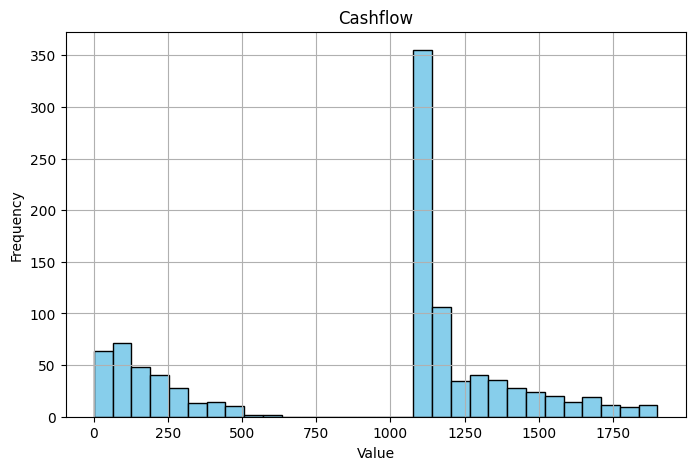

In [114]:
# plotting the histogram
plt.figure(figsize=(8, 5))
plt.hist(cash_flows, bins=30, color='skyblue', edgecolor='black')
plt.title("Cashflow")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [115]:
final_prices = normalized_paths[:, -1, :]  # shape (num_paths, num_assets)

print("Moyennes finales par actif :", final_prices.mean(axis=0))
print("Écarts-types finaux par actif :", final_prices.std(axis=0))
print("Quantiles finaux par actif :", np.quantile(final_prices, [0.05, 0.5, 0.95], axis=0))


Moyennes finales par actif : [4.28066345 1.34052676 1.61326216 1.65055964]
Écarts-types finaux par actif : [10.39709638  1.17036465  1.86780313  2.22070812]
Quantiles finaux par actif : [[ 0.06124036  0.27685692  0.21636352  0.21666297]
 [ 1.02440608  0.99162009  1.04387108  0.99052187]
 [21.40996309  3.64536747  4.89386731  5.367699  ]]


We did the same histogram, but for the classic Monte Carlo simualtion (not the Whisart process)

Mean : 932.9325


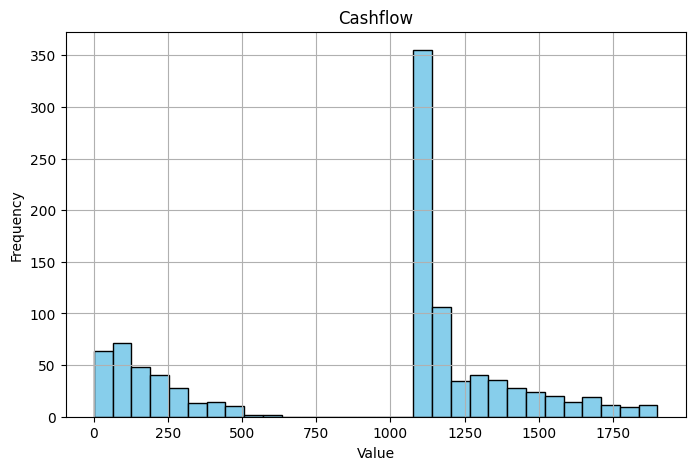

In [116]:
underlying_paths = all_paths
normalized_paths = underlying_paths / underlying_paths[:, 0, :][:, np.newaxis, :]
log_returns = np.log(normalized_paths[:, 1:, :] / normalized_paths[:, :-1, :])
vol_per_asset = np.std(log_returns, axis=(0, 1)) / np.sqrt(dt)  # annualisée

cash_flows , end_times = calculate_cash_flows(normalized_paths, interest_barrier, autocall_barriers, knock_in_barrier, interest_rate, observation_dates)
print("Mean :", cash_flows.mean())

# plotting the histogram
plt.figure(figsize=(8, 5))
plt.hist(cash_flows, bins=30, color='skyblue', edgecolor='black')
plt.title("Cashflow")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [117]:
discounted_cash_flows = cash_flows * np.exp(-mu * end_times)
price_MC = discounted_cash_flows.mean()
price_std_MC = discounted_cash_flows.std()
standard_error_MC = price_std_MC / np.sqrt(M)

print("Monte Carlo Pricing Summary for the Autocall Product")
print("="*50)
print(f"{'Mean discounted cashflow':<25}: {price_MC:,.2f} €")
print(f"{'Standard Deviation':<25}: {price_std_MC:,.2f} €")
print(f"{'Standard Error':<25}: {standard_error_MC:,.4f} €")
print(f"{'95% Confidence Interval':<25}: {price_MC:,.2f} € ± {1.96 * standard_error_MC:,.2f} €")

Monte Carlo Pricing Summary for the Autocall Product
Mean discounted cashflow : 931.20 €
Standard Deviation       : 519.40 €
Standard Error           : 16.4248 €
95% Confidence Interval  : 931.20 € ± 32.19 €


In [118]:
last_year_vols = { 
    rec['ticker']: rec['vol'] 
    for rec in volatility_records 
}

print(last_year_vols)
tickers = ['ASML', 'EN.PA', 'RI.PA', 'TTE.PA']
sigma_vector = np.array([last_year_vols[ticker] for ticker in tickers])

{'ASML': np.float64(0.42706763596751174), 'EN.PA': np.float64(0.19123642999565205), 'RI.PA': np.float64(0.23679415808106452), 'TTE.PA': np.float64(0.2502869332993179)}


In [119]:
all_paths_MC = monte_carlo_paths_tstudent_multivariate(S0, mu_multi, sigma_vector, T, N_steps, M, nu)

Mean : 989.145


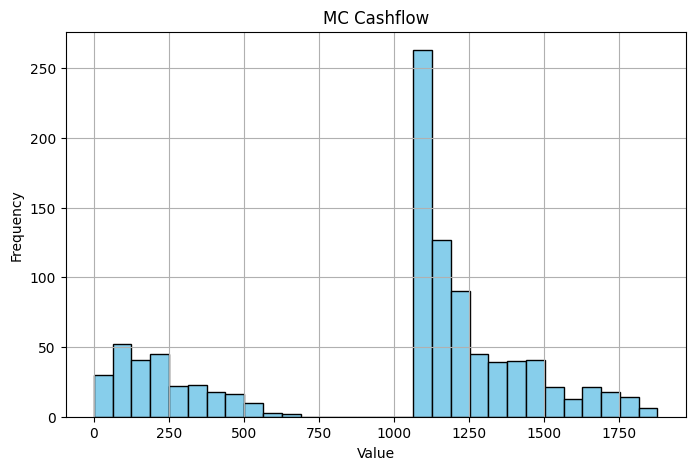

In [120]:
underlying_paths_MC = all_paths_MC
normalized_paths_MC = underlying_paths_MC / underlying_paths_MC[:, 0, :][:, np.newaxis, :]
log_returns_MC = np.log(normalized_paths_MC[:, 1:, :] / normalized_paths_MC[:, :-1, :])
vol_per_asset_MC = np.std(log_returns_MC, axis=(0, 1)) / np.sqrt(dt)  # annualisée

cash_flows_MC , end_times_MC = calculate_cash_flows(normalized_paths_MC, interest_barrier, autocall_barriers, knock_in_barrier, interest_rate, observation_dates)
print("Mean :", cash_flows_MC.mean())

# plotting the histogram
plt.figure(figsize=(8, 5))
plt.hist(cash_flows_MC, bins=30, color='skyblue', edgecolor='black')
plt.title("MC Cashflow")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [121]:
discounted_cash_flows_MC = cash_flows_MC * np.exp(-mu * end_times)
price_MC = discounted_cash_flows_MC.mean()
price_std_MC = discounted_cash_flows_MC.std()
standard_error_MC = price_std_MC / np.sqrt(M)

print("Monte Carlo Pricing Summary for the Autocall Product")
print("="*50)
print(f"{'Mean discounted cashflow':<25}: {price_MC:,.2f} €")
print(f"{'Standard Deviation':<25}: {price_std_MC:,.2f} €")
print(f"{'Standard Error':<25}: {standard_error_MC:,.4f} €")
print(f"{'95% Confidence Interval':<25}: {price_MC:,.2f} € ± {1.96 * standard_error_MC:,.2f} €")

Monte Carlo Pricing Summary for the Autocall Product
Mean discounted cashflow : 986.57 €
Standard Deviation       : 487.42 €
Standard Error           : 15.4137 €
95% Confidence Interval  : 986.57 € ± 30.21 €


In [122]:
invested_amount = 1000
losses = invested_amount - discounted_cash_flows
losses_sorted = np.sort(losses)
var_level = 0.95  # pour une VaR à 95%
var_index = int((1 - var_level) * len(losses_sorted))
var_95 = losses_sorted[var_index]
print(f"VaR at {int(var_level*100)}% on {invested_amount}€ invested, with the Whisart process: {var_95:.2f} €")


VaR at 95% on 1000€ invested, with the Whisart process: -623.88 €


In [123]:
losses_MC = invested_amount - discounted_cash_flows_MC
losses_sorted_MC = np.sort(losses_MC)
var_index_MC = int((1 - var_level) * len(losses_sorted_MC))
var_95_MC = losses_sorted_MC[var_index_MC]
print(f"VaR at {int(var_level*100)}% on {invested_amount}€ invested, with the classic MC simulation: {var_95_MC:.2f} €")

VaR at 95% on 1000€ invested, with the classic MC simulation: -645.63 €


This section analyzes the 10-year simulated returns of each individual stock and of an equally weighted portfolio composed of these stocks. It computes key statistics such as mean return, volatility, skewness, kurtosis, Value at Risk (VaR), Conditional VaR (CVaR), and probability of loss. Additionally, it visualizes the return distributions via histograms, calculates the correlation matrix of returns, and summarizes the main performance metrics to evaluate both individual asset risk/return profiles and portfolio diversification benefits over the investment horizon.


In [124]:
# Extract 10-year returns for each stock (final prices from normalized paths)
final_returns = normalized_paths[:, -1, :]  # Shape: (num_paths, num_assets)
stock_names = ['TTE.PA', 'ASML.AS', 'EN.PA', 'RI.PA']

print("10-Year Investment Returns Analysis")
print("="*50)

# Statistical analysis for each stock individually
for i, stock in enumerate(stock_names):
    returns = final_returns[:, i]
    
    print(f"\n{stock} - 10-Year Returns Statistics:")
    print(f"{'Mean Return':<20}: {returns.mean():.4f} ({(returns.mean()-1)*100:.2f}%)")
    print(f"{'Median Return':<20}: {np.median(returns):.4f} ({(np.median(returns)-1)*100:.2f}%)")
    print(f"{'Standard Deviation':<20}: {returns.std():.4f}")
    print(f"{'Volatility (annual)':<20}: {returns.std()/np.sqrt(10):.4f}")
    print(f"{'Skewness':<20}: {stats.skew(returns):.4f}")
    print(f"{'Kurtosis':<20}: {stats.kurtosis(returns, fisher=False):.4f}")
    print(f"{'Min Return':<20}: {returns.min():.4f} ({(returns.min()-1)*100:.2f}%)")
    print(f"{'Max Return':<20}: {returns.max():.4f} ({(returns.max()-1)*100:.2f}%)")
    
    # Quantiles
    q05, q25, q75, q95 = np.percentile(returns, [5, 25, 75, 95])
    print(f"{'5th Percentile':<20}: {q05:.4f} ({(q05-1)*100:.2f}%)")
    print(f"{'25th Percentile':<20}: {q25:.4f} ({(q25-1)*100:.2f}%)")
    print(f"{'75th Percentile':<20}: {q75:.4f} ({(q75-1)*100:.2f}%)")
    print(f"{'95th Percentile':<20}: {q95:.4f} ({(q95-1)*100:.2f}%)")
    
    # Risk metrics
    var_5 = np.percentile(returns, 5)
    cvar_5 = returns[returns <= var_5].mean()
    print(f"{'VaR (5%)':<20}: {var_5:.4f} ({(var_5-1)*100:.2f}%)")
    print(f"{'CVaR (5%)':<20}: {cvar_5:.4f} ({(cvar_5-1)*100:.2f}%)")
    
    # Probability of loss
    prob_loss = np.mean(returns < 1.0)
    print(f"{'Prob of Loss':<20}: {prob_loss:.4f} ({prob_loss*100:.2f}%)")
    
    print("-" * 50)

10-Year Investment Returns Analysis

TTE.PA - 10-Year Returns Statistics:
Mean Return         : 4.2807 (328.07%)
Median Return       : 1.0244 (2.44%)
Standard Deviation  : 10.3971
Volatility (annual) : 3.2879
Skewness            : 5.7189
Kurtosis            : 47.2248
Min Return          : 0.0009 (-99.91%)
Max Return          : 123.2301 (12223.01%)
5th Percentile      : 0.0612 (-93.88%)
25th Percentile     : 0.2772 (-72.28%)
75th Percentile     : 3.5605 (256.05%)
95th Percentile     : 21.4100 (2041.00%)
VaR (5%)            : 0.0612 (-93.88%)
CVaR (5%)           : 0.0331 (-96.69%)
Prob of Loss        : 0.4930 (49.30%)
--------------------------------------------------

ASML.AS - 10-Year Returns Statistics:
Mean Return         : 1.3405 (34.05%)
Median Return       : 0.9916 (-0.84%)
Standard Deviation  : 1.1704
Volatility (annual) : 0.3701
Skewness            : 2.5967
Kurtosis            : 12.7205
Min Return          : 0.0811 (-91.89%)
Max Return          : 9.7122 (871.22%)
5th Percentile 

In [125]:
# Equally weighted portfolio analysis (25% each stock)
portfolio_weights = np.array([0.25, 0.25, 0.25, 0.25])
portfolio_returns = np.dot(final_returns, portfolio_weights)

print("\nEqually Weighted Portfolio (25% each stock) - 10-Year Returns:")
print("="*60)
print(f"{'Mean Return':<20}: {portfolio_returns.mean():.4f} ({(portfolio_returns.mean()-1)*100:.2f}%)")
print(f"{'Median Return':<20}: {np.median(portfolio_returns):.4f} ({(np.median(portfolio_returns)-1)*100:.2f}%)")
print(f"{'Standard Deviation':<20}: {portfolio_returns.std():.4f}")
print(f"{'Volatility (annual)':<20}: {portfolio_returns.std()/np.sqrt(10):.4f}")
print(f"{'Skewness':<20}: {stats.skew(portfolio_returns):.4f}")
print(f"{'Kurtosis':<20}: {stats.kurtosis(portfolio_returns, fisher=False):.4f}")
print(f"{'Min Return':<20}: {portfolio_returns.min():.4f} ({(portfolio_returns.min()-1)*100:.2f}%)")
print(f"{'Max Return':<20}: {portfolio_returns.max():.4f} ({(portfolio_returns.max()-1)*100:.2f}%)")

# Quantiles for portfolio
q05_p, q25_p, q75_p, q95_p = np.percentile(portfolio_returns, [5, 25, 75, 95])
print(f"{'5th Percentile':<20}: {q05_p:.4f} ({(q05_p-1)*100:.2f}%)")
print(f"{'25th Percentile':<20}: {q25_p:.4f} ({(q25_p-1)*100:.2f}%)")
print(f"{'75th Percentile':<20}: {q75_p:.4f} ({(q75_p-1)*100:.2f}%)")
print(f"{'95th Percentile':<20}: {q95_p:.4f} ({(q95_p-1)*100:.2f}%)")

# Risk metrics for portfolio
var_5_p = np.percentile(portfolio_returns, 5)
cvar_5_p = portfolio_returns[portfolio_returns <= var_5_p].mean()
print(f"{'VaR (5%)':<20}: {var_5_p:.4f} ({(var_5_p-1)*100:.2f}%)")
print(f"{'CVaR (5%)':<20}: {cvar_5_p:.4f} ({(cvar_5_p-1)*100:.2f}%)")

# Probability of loss for portfolio
prob_loss_p = np.mean(portfolio_returns < 1.0)
print(f"{'Prob of Loss':<20}: {prob_loss_p:.4f} ({prob_loss_p*100:.2f}%)")

# Annualized return and Sharpe ratio
annual_return_p = (portfolio_returns.mean() ** (1/10)) - 1
annual_vol_p = portfolio_returns.std() / np.sqrt(10)
sharpe_ratio_p = (annual_return_p - mu) / annual_vol_p
print(f"{'Annual Return':<20}: {annual_return_p:.4f} ({annual_return_p*100:.2f}%)")
print(f"{'Sharpe Ratio':<20}: {sharpe_ratio_p:.4f}")


Equally Weighted Portfolio (25% each stock) - 10-Year Returns:
Mean Return         : 2.2213 (122.13%)
Median Return       : 1.4253 (42.53%)
Standard Deviation  : 2.8336
Volatility (annual) : 0.8961
Skewness            : 4.8774
Kurtosis            : 37.1767
Min Return          : 0.2222 (-77.78%)
Max Return          : 32.9322 (3193.22%)
5th Percentile      : 0.4277 (-57.23%)
25th Percentile     : 0.8563 (-14.37%)
75th Percentile     : 2.3737 (137.37%)
95th Percentile     : 6.8646 (586.46%)
VaR (5%)            : 0.4277 (-57.23%)
CVaR (5%)           : 0.3369 (-66.31%)
Prob of Loss        : 0.3100 (31.00%)
Annual Return       : 0.0831 (8.31%)
Sharpe Ratio        : 0.0921


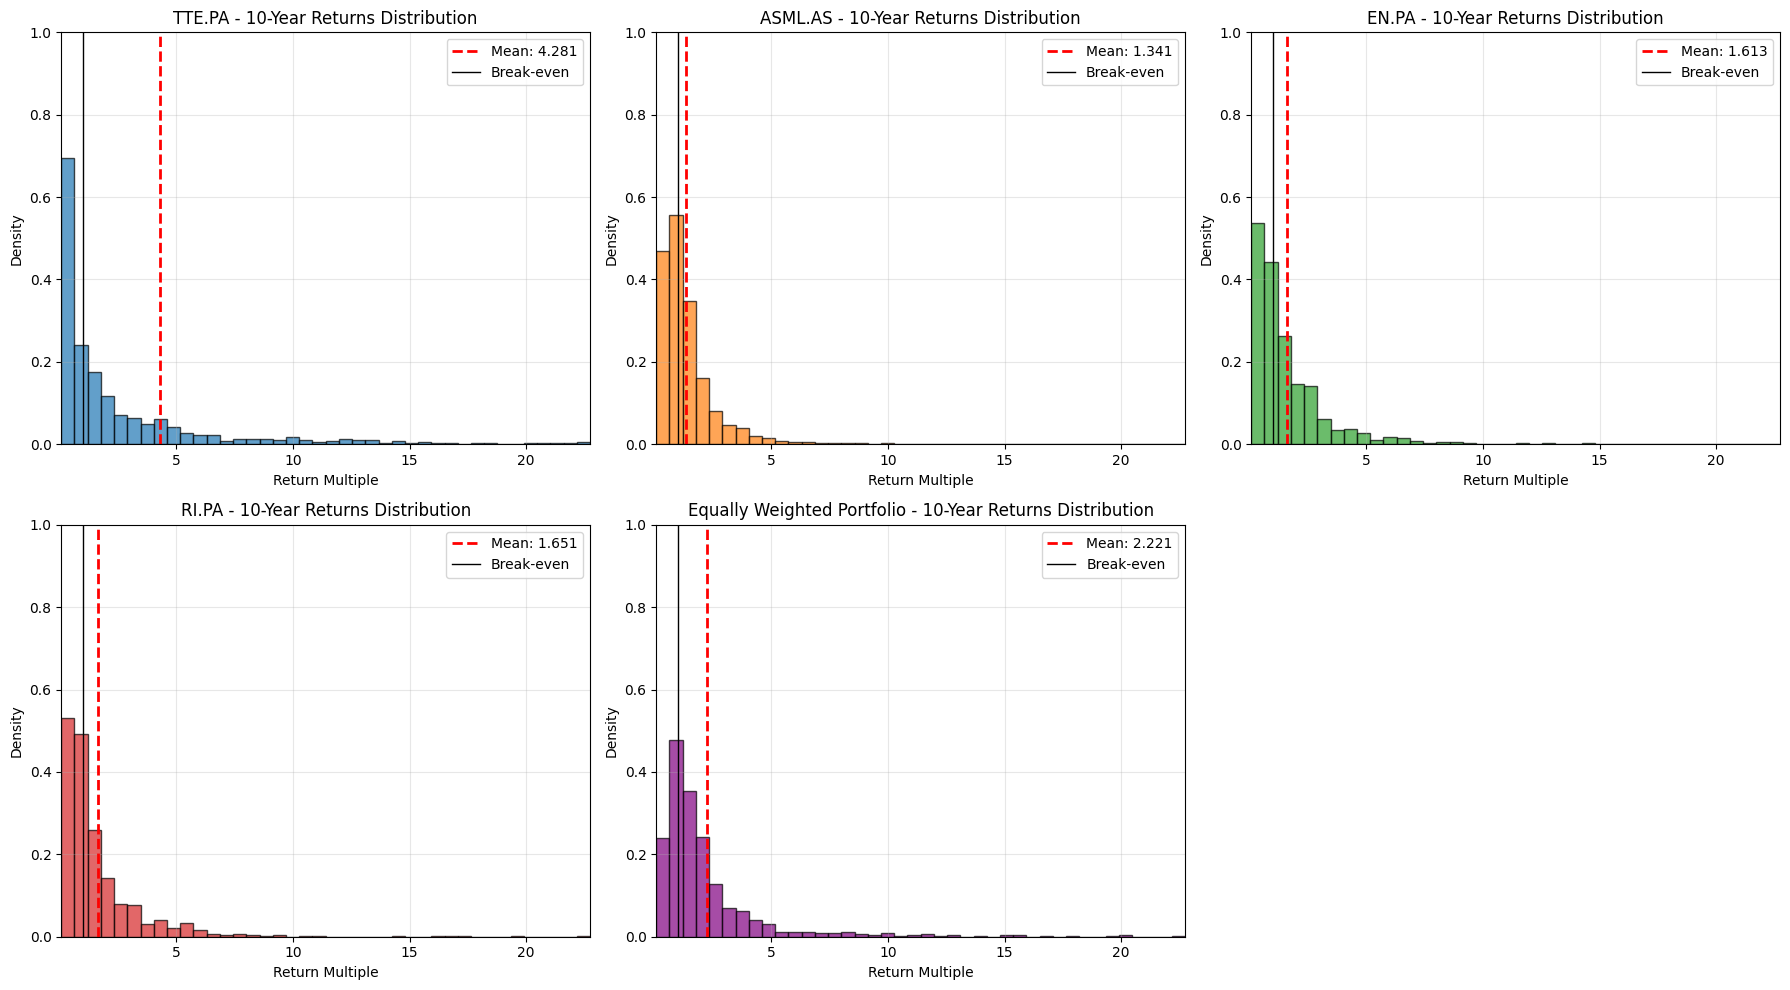

In [126]:
# Visualization of return distributions with standardized axes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Calculate reasonable x-axis limits excluding outliers (using 1st and 99th percentiles)
all_returns = np.concatenate([final_returns.flatten(), portfolio_returns])
x_min = max(0, np.percentile(all_returns, 1))  # 1st percentile, but at least 0
x_max = np.percentile(all_returns, 99)  # 99th percentile to exclude outliers

# Define consistent bin edges for all plots
bin_edges = np.linspace(x_min, x_max, 41)  # 40 bins with consistent width

# Plot histograms for each stock
for i, stock in enumerate(stock_names):
    returns = final_returns[:, i]
    axes[i].hist(returns, bins=bin_edges, alpha=0.7, density=True, color=f'C{i}', edgecolor='black')
    axes[i].axvline(returns.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns.mean():.3f}')
    axes[i].axvline(1.0, color='black', linestyle='-', linewidth=1, label='Break-even')
    axes[i].set_title(f'{stock} - 10-Year Returns Distribution')
    axes[i].set_xlabel('Return Multiple')
    axes[i].set_ylabel('Density')
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(0, 1)  # Standardized y-axis
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Plot histogram for equally weighted portfolio
axes[4].hist(portfolio_returns, bins=bin_edges, alpha=0.7, density=True, color='purple', edgecolor='black')
axes[4].axvline(portfolio_returns.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {portfolio_returns.mean():.3f}')
axes[4].axvline(1.0, color='black', linestyle='-', linewidth=1, label='Break-even')
axes[4].set_title('Equally Weighted Portfolio - 10-Year Returns Distribution')
axes[4].set_xlabel('Return Multiple')
axes[4].set_ylabel('Density')
axes[4].set_xlim(x_min, x_max)
axes[4].set_ylim(0, 1)  # Standardized y-axis
axes[4].legend()
axes[4].grid(True, alpha=0.3)

# Remove the empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

In [127]:
# Correlation analysis of 10-year returns
print("\nCorrelation Matrix of 10-Year Returns:")
print("="*40)
return_corr = np.corrcoef(final_returns.T)
return_corr_df = pd.DataFrame(return_corr, index=stock_names, columns=stock_names)
print(return_corr_df.round(4))

# Create concise comparative statistics table - Key metrics only
stats_data = []
for i, stock in enumerate(stock_names):
    returns = final_returns[:, i]
    stats_data.append({
        'Asset': stock,
        'Mean Return (%)': f"{((returns.mean()-1)*100):.1f}%",
        'Std Dev (%)': f"{(returns.std()*100):.1f}%",
        'VaR 5% (%)': f"{((np.percentile(returns, 5)-1)*100):.1f}%",
        'Prob Loss (%)': f"{(np.mean(returns < 1.0)*100):.1f}%",
        'Best/Worst': f"{returns.max():.2f}/{returns.min():.2f}"
    })

# Add portfolio statistics
stats_data.append({
    'Asset': 'Equal Portfolio',
    'Mean Return (%)': f"{((portfolio_returns.mean()-1)*100):.1f}%",
    'Std Dev (%)': f"{(portfolio_returns.std()*100):.1f}%",
    'VaR 5% (%)': f"{((np.percentile(portfolio_returns, 5)-1)*100):.1f}%",
    'Prob Loss (%)': f"{(np.mean(portfolio_returns < 1.0)*100):.1f}%",
    'Best/Worst': f"{portfolio_returns.max():.2f}/{portfolio_returns.min():.2f}"
})

stats_df = pd.DataFrame(stats_data)
print("\n\nKey Performance Metrics Summary:")
print("="*65)
print(stats_df.to_string(index=False))


Correlation Matrix of 10-Year Returns:
         TTE.PA  ASML.AS   EN.PA   RI.PA
TTE.PA   1.0000   0.1113  0.0215  0.0889
ASML.AS  0.1113   1.0000  0.1968  0.2096
EN.PA    0.0215   0.1968  1.0000  0.1185
RI.PA    0.0889   0.2096  0.1185  1.0000


Key Performance Metrics Summary:
          Asset Mean Return (%) Std Dev (%) VaR 5% (%) Prob Loss (%)  Best/Worst
         TTE.PA          328.1%     1039.7%     -93.9%         49.3% 123.23/0.00
        ASML.AS           34.1%      117.0%     -72.3%         50.4%   9.71/0.08
          EN.PA           61.3%      186.8%     -78.4%         48.0%  28.07/0.06
          RI.PA           65.1%      222.1%     -78.3%         50.8%  31.64/0.03
Equal Portfolio          122.1%      283.4%     -57.2%         31.0%  32.93/0.22
